In [2]:
!pip install torchtext datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# SST2 (NLP dataset)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loading SST-2...

--- SST-2: Training with Nova ---
Epoch 1/20 - Train Loss: 0.6308, Train Acc: 0.6518, Val Loss: 0.5354, Val Acc: 0.7553
Epoch 2/20 - Train Loss: 0.4508, Train Acc: 0.8163, Val Loss: 0.4015, Val Acc: 0.8393
Epoch 3/20 - Train Loss: 0.3499, Train Acc: 0.8686, Val Loss: 0.3438, Val Acc: 0.8650
Epoch 4/20 - Train Loss: 0.3010, Train Acc: 0.8907, Val Loss: 0.3126, Val Acc: 0.8733
Epoch 5/20 - Train Loss: 0.2703, Train Acc: 0.9042, Val Loss: 0.2934, Val Acc: 0.8824
Epoch 6/20 - Train Loss: 0.2499, Train Acc: 0.9120, Val Loss: 0.2807, Val Acc: 0.8880
Epoch 7/20 - Train Loss: 0.2353, Train Acc: 0.9175, Val Loss: 0.2722, Val Acc: 0.8927
Epoch 8/20 - Train Loss: 0.2238, Train Acc: 0.9219, Val Loss: 0.2659, Val Acc: 0.8959
Epoch 9/20 - Train Loss: 0.2148, Train Acc: 0.9256, Val Loss: 0.2610, Val Acc: 0.8984
Epoch 10/20 - Train Loss: 0.2078, Train Acc: 0.9287, Val Loss: 0.2574, Val Acc: 0.8999
Epoch 11/20 - Train Loss: 0.2020, Train Acc: 0.9302, Val Loss: 0.2545, Val Acc: 0.9017


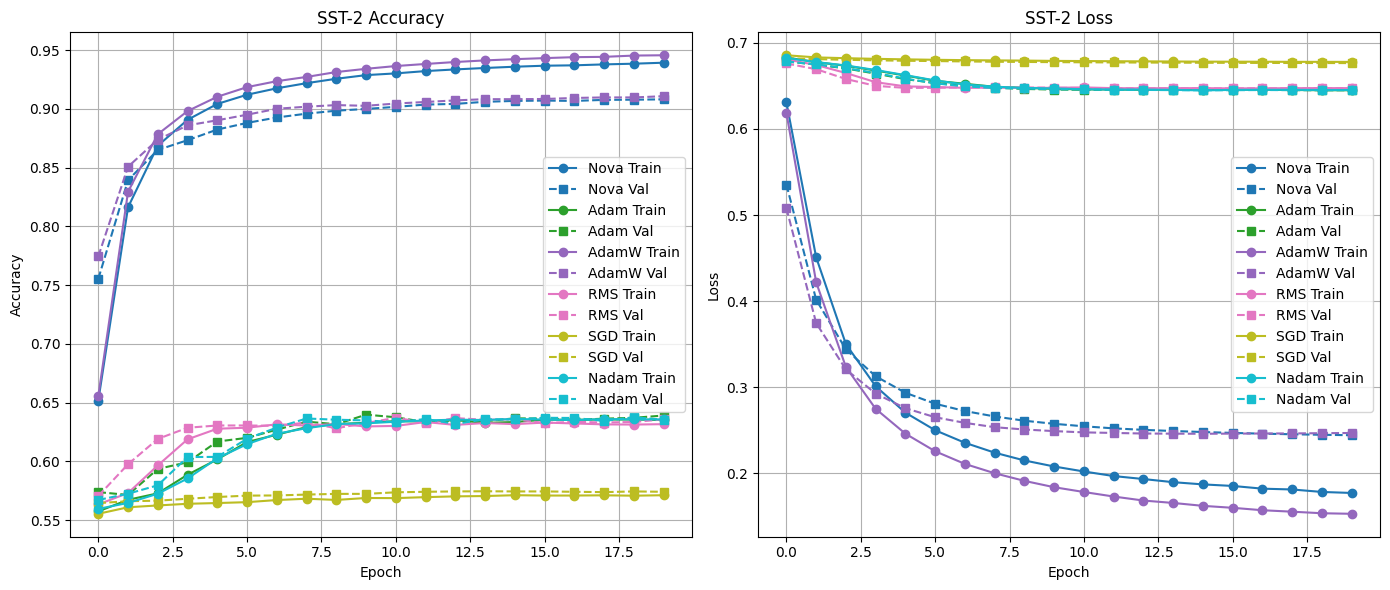

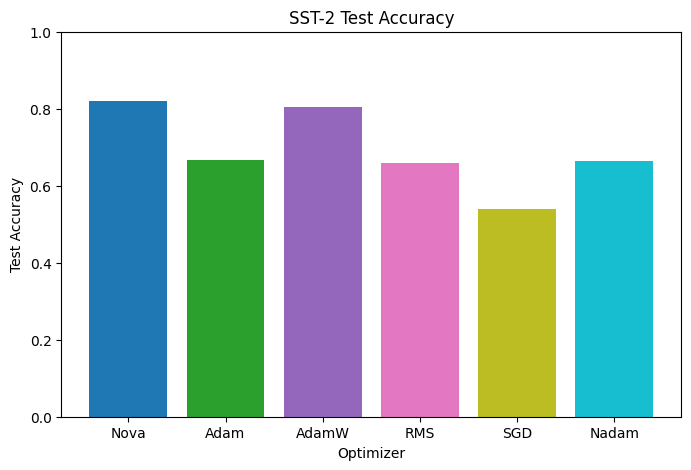

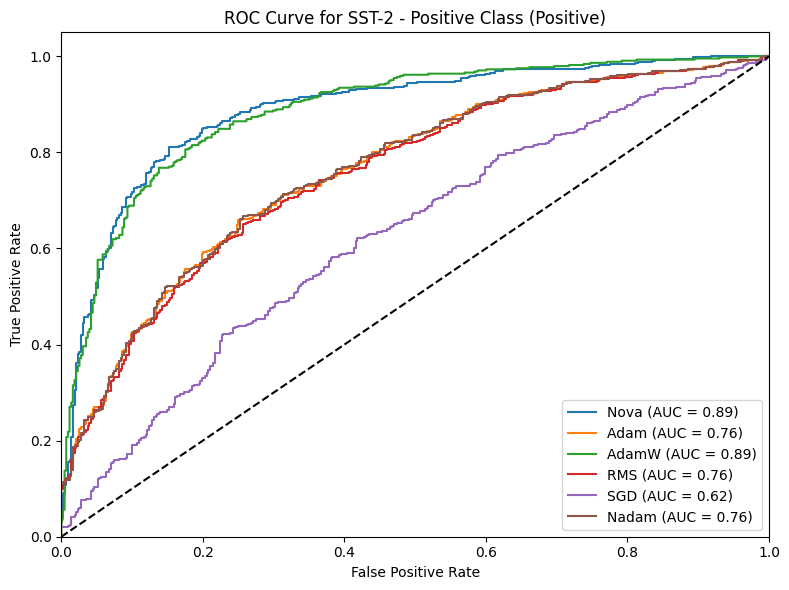

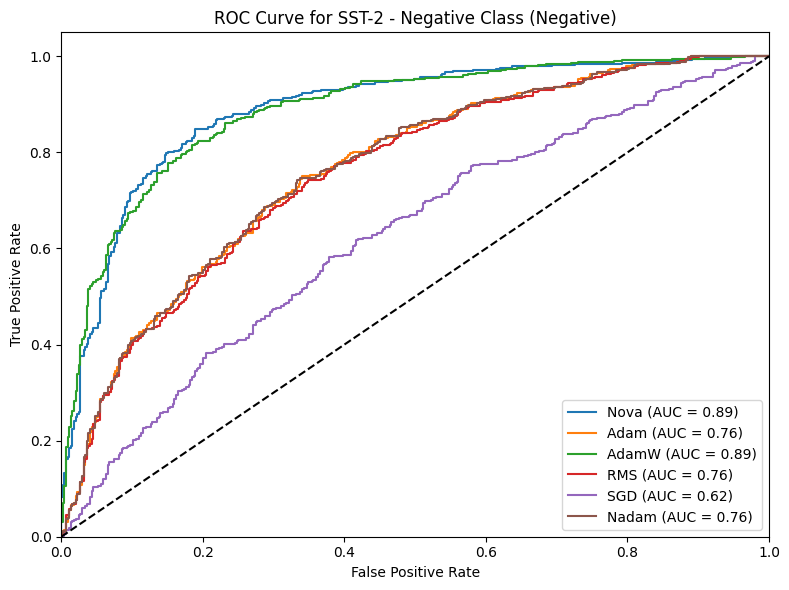

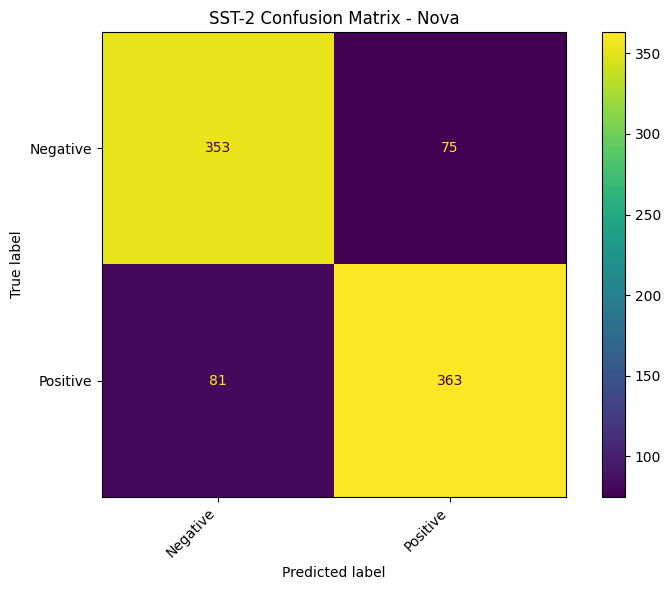

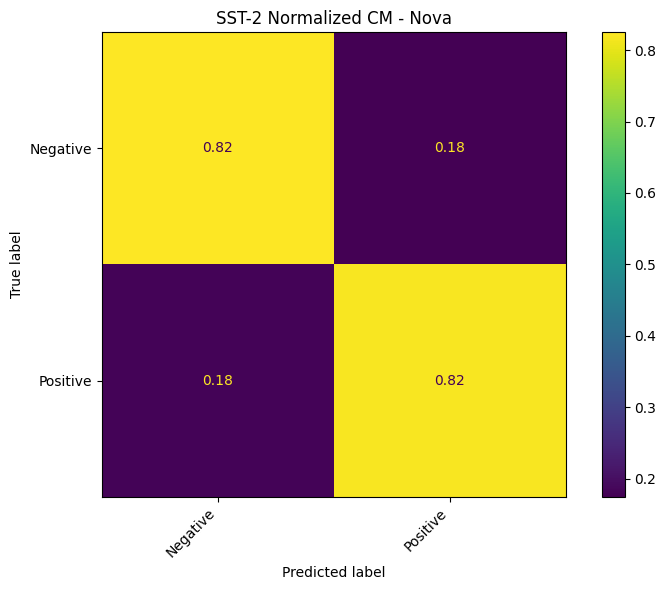

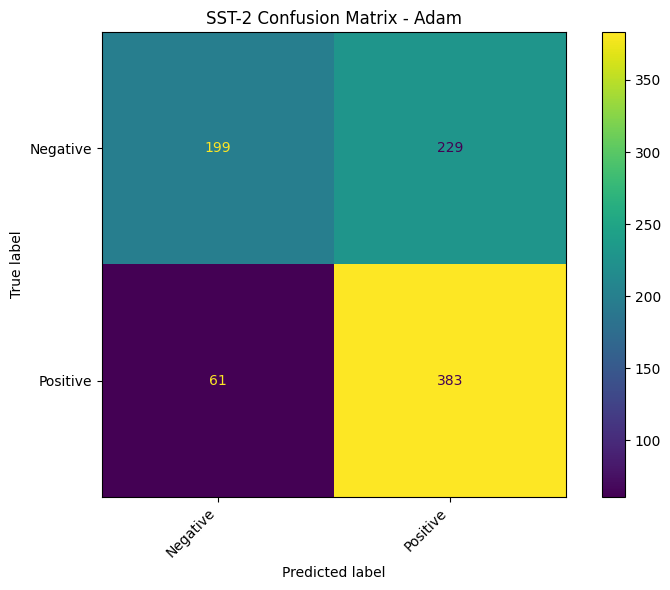

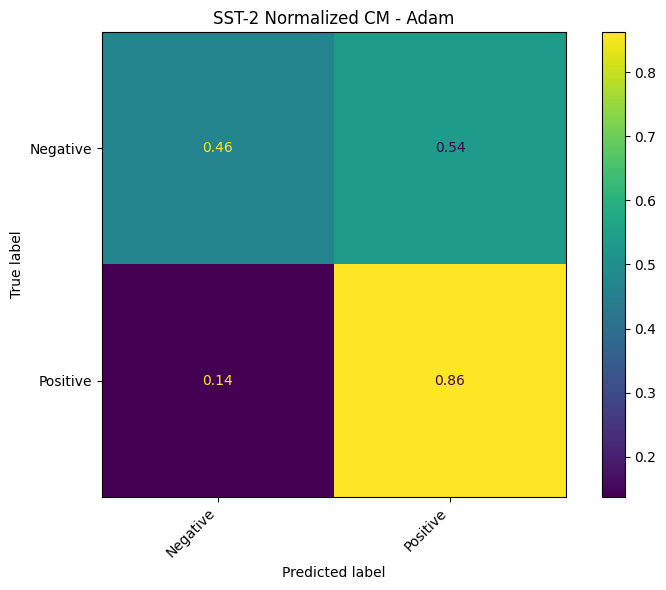

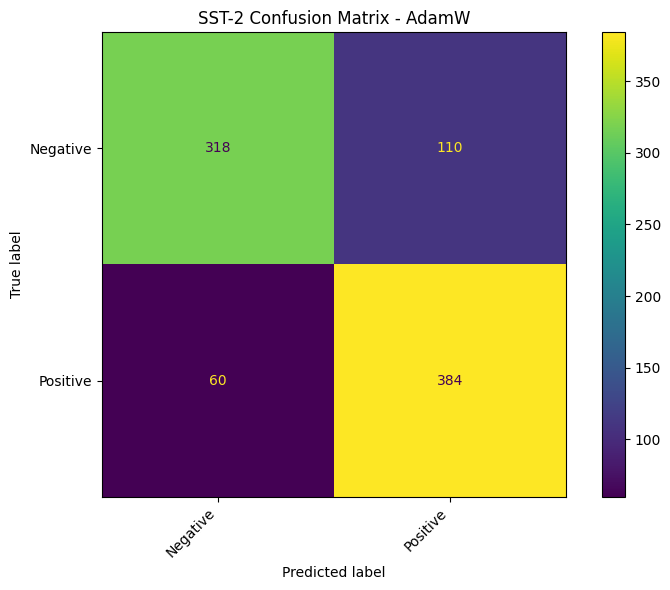

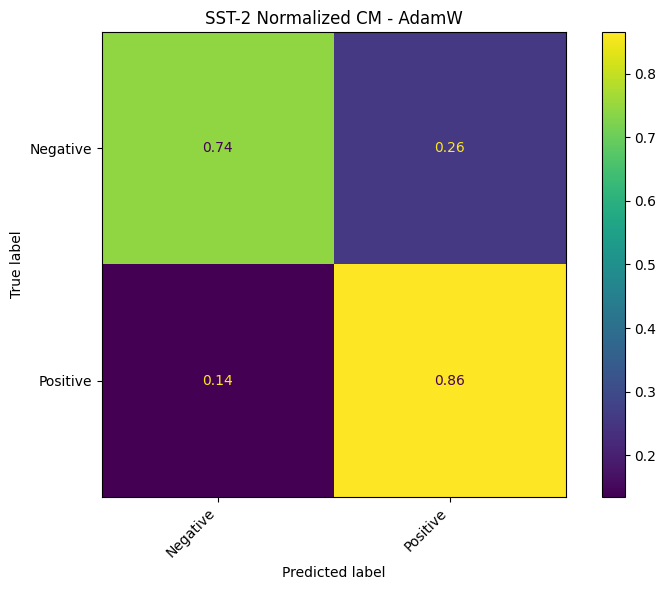

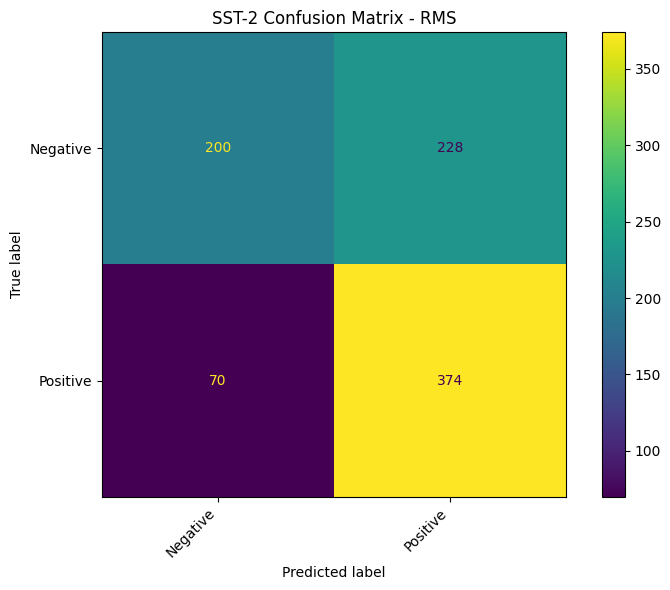

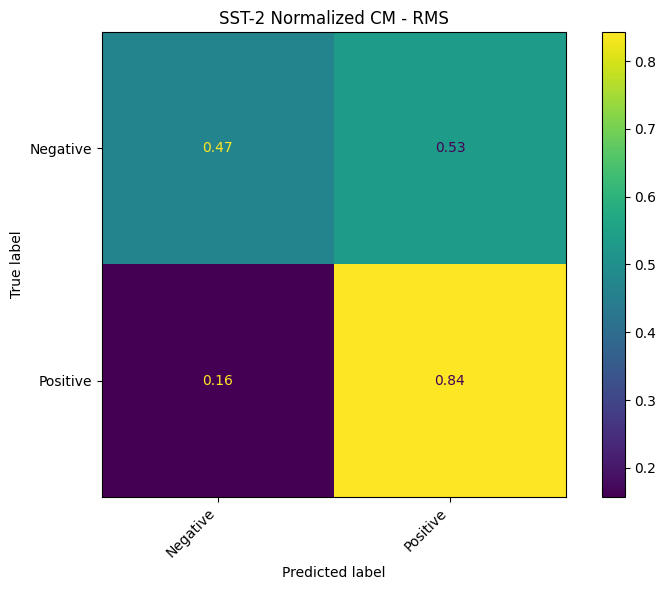

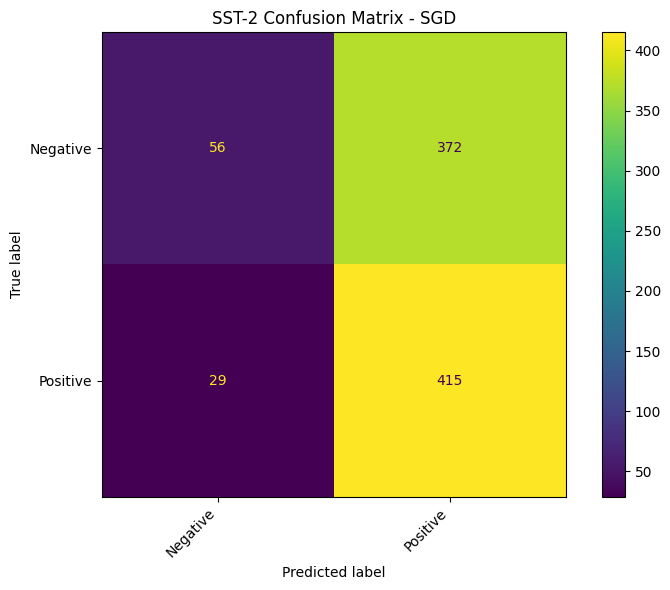

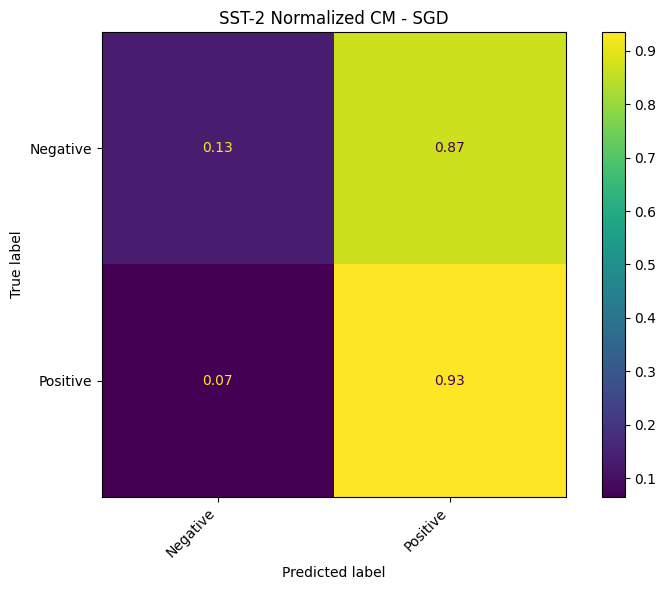

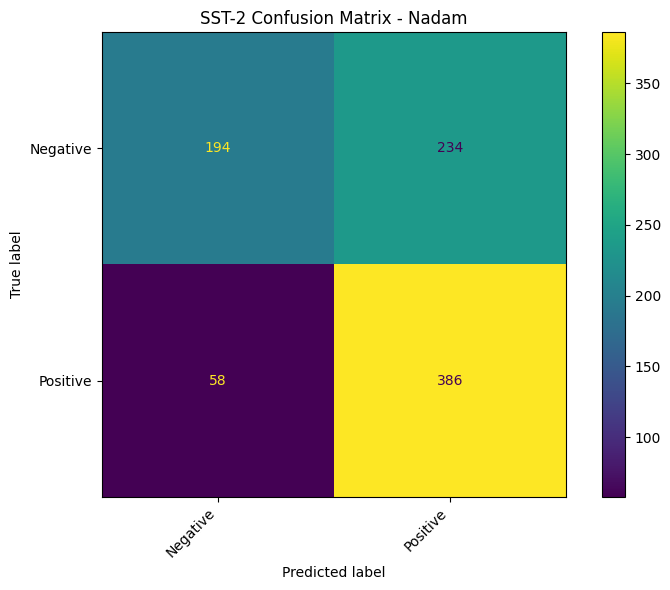

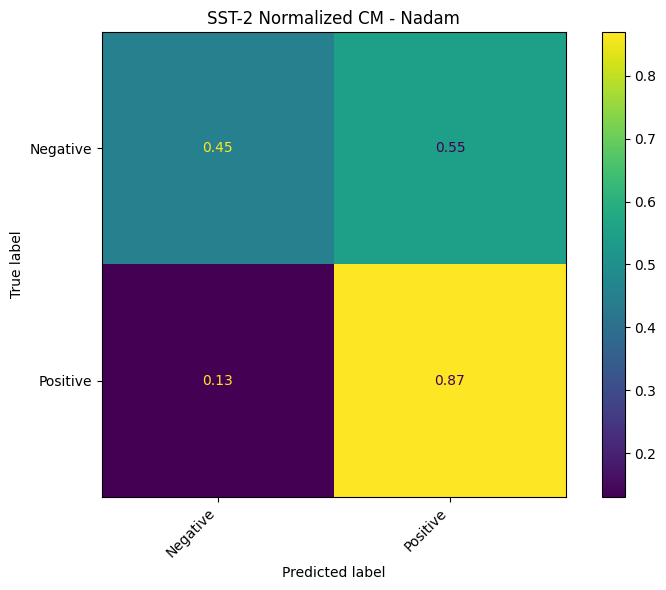

In [2]:
import os
import random
import time
from collections import Counter
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Setup & Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
nltk.download('punkt', quiet=True)

num_epochs = 20

# Nova Optimizer Definition
class Nova(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Nova does not support sparse gradients')

                state = self.state[p]
                if not state:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_max'] = torch.zeros_like(p.data)

                beta1, beta2 = group['betas']
                lr, wd, eps = group['lr'], group['weight_decay'], group['eps']
                state['step'] += 1
                t = state['step']

                if wd != 0:
                    p.data.add_(p.data, alpha=-lr * wd)

                m, v, v_hat_max = state['m'], state['v'], state['v_hat_max']
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                m_nes = m * beta1 + grad * (1 - beta1)
                m_hat = m_nes / (1 - beta1 ** t)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                v_hat = v / (1 - beta2 ** t)
                state['v_hat_max'] = torch.max(v_hat_max, v_hat)

                denom = state['v_hat_max'].sqrt().add_(eps)
                p.data.addcdiv_(m_hat, denom, value=-lr)
        return loss

# Text Classification Model for SST-2
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_class=2, pad_idx=1):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.classifier = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        emb = self.embedding(text)
        pooled = emb.mean(dim=1)
        return self.classifier(pooled)

# Data Preparation: SST-2
print("Loading SST-2...")
dataset = load_dataset("sst2")
train_raw, val_raw = random_split(dataset['train'], [int(0.9*len(dataset['train'])), len(dataset['train'])-int(0.9*len(dataset['train']))])
test_raw = dataset['validation']

counter = Counter()
for item in train_raw:
    tokens = word_tokenize(item['sentence'].lower())
    counter.update(tokens)
vocab = {'<unk>':0, '<pad>':1}
for i, tok in enumerate(counter, start=2): vocab[tok] = i
pad_idx = vocab['<pad>']
unk_idx = vocab['<unk>']

def text_pipeline(text):
    return [vocab.get(tok, unk_idx) for tok in word_tokenize(text.lower())]

class SST2Dataset(Dataset):
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx): return self.subset[idx]['sentence'], self.subset[idx]['label']

def collate_batch(batch):
    texts, labels = zip(*batch)
    seqs = [torch.tensor(text_pipeline(t), dtype=torch.long) for t in texts]
    padded = pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    return padded, torch.tensor(labels, dtype=torch.long)

train_loader_sst2 = DataLoader(SST2Dataset(train_raw), batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader_sst2 = DataLoader(SST2Dataset(val_raw), batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader_sst2 = DataLoader(SST2Dataset(test_raw), batch_size=64, shuffle=False, collate_fn=collate_batch)

sst2_class_names = ['Negative', 'Positive']

# Generic Train Model Function (Updated)
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader,
                num_epochs=num_epochs, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
        train_loss /= total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, preds = outputs.max(1)
                val_total += targets.size(0)
                val_correct += preds.eq(targets).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # Test evaluation
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            test_correct += preds.eq(targets).sum().item()
            test_total += targets.size(0)

    # Convert collected lists to NumPy arrays
    all_probs = np.vstack(all_probs)  # Shape: (total_samples, num_class)
    all_targets = np.array(all_targets)  # Shape: (total_samples,)
    all_preds = np.array(all_preds)  # Shape: (total_samples,)

    test_loss /= test_total
    test_acc = test_correct / test_total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # Compute ROC curve and AUC for binary classification (both classes)
    if all_probs.shape[1] == 2:  # Binary classification
        # Positive class (label 1)
        fpr_pos, tpr_pos, _ = roc_curve(all_targets, all_probs[:, 1])
        roc_auc_pos = auc(fpr_pos, tpr_pos)
        # Negative class (label 0)
        fpr_neg, tpr_neg, _ = roc_curve(all_targets, all_probs[:, 0], pos_label=0)
        roc_auc_neg = auc(fpr_neg, tpr_neg)

        history['fpr_pos'] = fpr_pos
        history['tpr_pos'] = tpr_pos
        history['roc_auc_pos'] = roc_auc_pos
        history['fpr_neg'] = fpr_neg
        history['tpr_neg'] = tpr_neg
        history['roc_auc_neg'] = roc_auc_neg
        # Keep 'roc_auc' for compatibility with existing table (Positive class)
        history['roc_auc'] = roc_auc_pos

    history.update({
        'test_loss': test_loss, 'test_acc': test_acc,
        'precision': precision, 'recall': recall, 'f1': f1,
        'runtime': time.time() - start_time,
        'targets': all_targets, 'probs': all_probs
    })

    print(f"\nFinal Results on {dataset_name}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    if 'roc_auc' in history:
        print(f"AUC (Positive): {history['roc_auc_pos']:.4f}, AUC (Negative): {history['roc_auc_neg']:.4f}")

    return history

# Optimizers
optimizers = {
    'Nova':  lambda p: Nova(p, lr=1e-3, weight_decay=1e-3),
    'Adam':  lambda p: optim.Adam(p, lr=1e-3, weight_decay=1e-3),
    'AdamW': lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-3),
    'RMS':   lambda p: optim.RMSprop(p, lr=1e-3, weight_decay=1e-3),
    'SGD':   lambda p: optim.SGD(p, lr=1e-3, momentum=0.9, weight_decay=1e-3),
    'Nadam': lambda p: optim.NAdam(p, lr=1e-3, weight_decay=1e-3),
}

# Run Experiments for SST-2
results_sst2 = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- SST-2: Training with {opt_name} ---')
    results_sst2[opt_name] = train_model(
        lambda: TextClassificationModel(len(vocab), 64, 2, pad_idx),
        opt_factory,
        train_loader_sst2,
        val_loader_sst2,
        test_loader_sst2,
        num_epochs=num_epochs,
        dataset_name="SST-2"
    )

# Plotting Functions (Updated plot_roc_curves)
def plot_learning_curves(results, dataset_name, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    for idx, opt in enumerate(results):
        axes[0].plot(results[opt]['train_acc'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[0].plot(results[opt]['val_acc'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[0].set_title(f'{dataset_name} Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    for idx, opt in enumerate(results):
        axes[1].plot(results[opt]['train_loss'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[1].plot(results[opt]['val_loss'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[1].set_title(f'{dataset_name} Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_learning_curves.png')

def plot_test_accuracy(results, dataset_name):
    final_acc = {opt: results[opt]['test_acc'] for opt in results}
    colors = plt.cm.tab10(np.linspace(0, 1, len(final_acc)))
    plt.figure(figsize=(8, 5))
    plt.bar(final_acc.keys(), final_acc.values(), color=colors)
    plt.ylim(0, 1)
    plt.title(f'{dataset_name} Test Accuracy')
    plt.xlabel('Optimizer')
    plt.ylabel('Test Accuracy')
    # plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_test_accuracy.png')

def plot_roc_curves(results, dataset_name, class_names):
    if len(class_names) == 2:  # Binary classification
        # Plot ROC for Positive class
        plt.figure(figsize=(8, 6))
        for opt in results:
            if 'fpr_pos' in results[opt]:
                fpr = results[opt]['fpr_pos']
                tpr = results[opt]['tpr_pos']
                roc_auc = results[opt]['roc_auc_pos']
                plt.plot(fpr, tpr, label=f'{opt} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {dataset_name} - Positive Class ({class_names[1]})')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f'{dataset_name.lower()}_roc_positive.png')

        # Plot ROC for Negative class
        plt.figure(figsize=(8, 6))
        for opt in results:
            if 'fpr_neg' in results[opt]:
                fpr = results[opt]['fpr_neg']
                tpr = results[opt]['tpr_neg']
                roc_auc = results[opt]['roc_auc_neg']
                plt.plot(fpr, tpr, label=f'{opt} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {dataset_name} - Negative Class ({class_names[0]})')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f'{dataset_name.lower()}_roc_negative.png')
    else:
        print("ROC curve plotting is only implemented for binary classification.")

def plot_confusion_matrix(cm, class_names, title, normalize=False, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        values_format = '.2f'
    else:
        values_format = 'd'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)

# Generate Plots for SST-2
plot_learning_curves(results_sst2, "SST-2", sst2_class_names)
plot_test_accuracy(results_sst2, "SST-2")
plot_roc_curves(results_sst2, "SST-2", sst2_class_names)
for opt in results_sst2:
    cm = confusion_matrix(results_sst2[opt]['targets'], np.argmax(results_sst2[opt]['probs'], axis=1))
    plot_confusion_matrix(cm, sst2_class_names, f'SST-2 Confusion Matrix - {opt}', save_path=f'sst2_cm_{opt}.png')
    plot_confusion_matrix(cm, sst2_class_names, f'SST-2 Normalized CM - {opt}', normalize=True, save_path=f'sst2_cm_normalized_{opt}.png')

# LaTeX Table Generation Functions
def generate_performance_table(results, dataset_name):
    table = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        "\\caption{Performance metrics on " + dataset_name + "}\n"
        "\\begin{tabular}{lccccccc}\n"
        "\\toprule\n"
        "Optimizer & Train Loss & Train Acc (\\%) & Val Loss & Val Acc (\\%) & Test Loss & Test Acc (\\%) & Time per Epoch (s) \\\\\n"
        "\\midrule\n"
    )
    for opt, m in results.items():
        train_loss = m['train_loss'][-1]
        train_acc = m['train_acc'][-1] * 100
        val_loss = m['val_loss'][-1]
        val_acc = m['val_acc'][-1] * 100
        test_loss = m['test_loss']
        test_acc = m['test_acc'] * 100
        average_time_per_epoch = m['runtime'] / num_epochs
        table += (
            f"{opt} & {train_loss:.4f} & {train_acc:.2f} & {val_loss:.4f} & {val_acc:.2f} & {test_loss:.4f} & {test_acc:.2f} & {average_time_per_epoch:.2f} \\\\\n"
        )
    table += (
        "\\bottomrule\n"
        "\\end{tabular}\n"
        f"\\label{{tab:{dataset_name.lower()}_main}}\n"
        "\\end{table}\n"
    )
    return table

def generate_classification_table(results, dataset_name):
    table = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        "\\caption{Classification metrics on " + dataset_name + "}\n"
        "\\begin{tabular}{lcccc}\n"
        "\\toprule\n"
        "Optimizer & Precision (\\%) & Recall (\\%) & F1-score (\\%) & AUC \\\\\n"
        "\\midrule\n"
    )
    for opt, m in results.items():
        precision = m['precision'] * 100
        recall = m['recall'] * 100
        f1 = m['f1'] * 100
        auc_value = m.get('roc_auc', 'N/A')
        if auc_value != 'N/A':
            auc_value = f"{auc_value:.2f}"
        table += (
            f"{opt} & {precision:.2f} & {recall:.2f} & {f1:.2f} & {auc_value} \\\\\n"
        )
    table += (
        "\\bottomrule\n"
        "\\end{tabular}\n"
        f"\\label{{tab:{dataset_name.lower()}_prf}}\n"
        "\\end{table}\n"
    )
    return table

# Print LaTeX Tables for SST-2
print("\n=== LaTeX Performance Table for SST-2 ===\n", generate_performance_table(results_sst2, "SST-2"))
print("\n=== LaTeX Classification Table for SST-2 ===\n", generate_classification_table(results_sst2, "SST-2"))

# Noisy MNIST 

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.48MB/s]


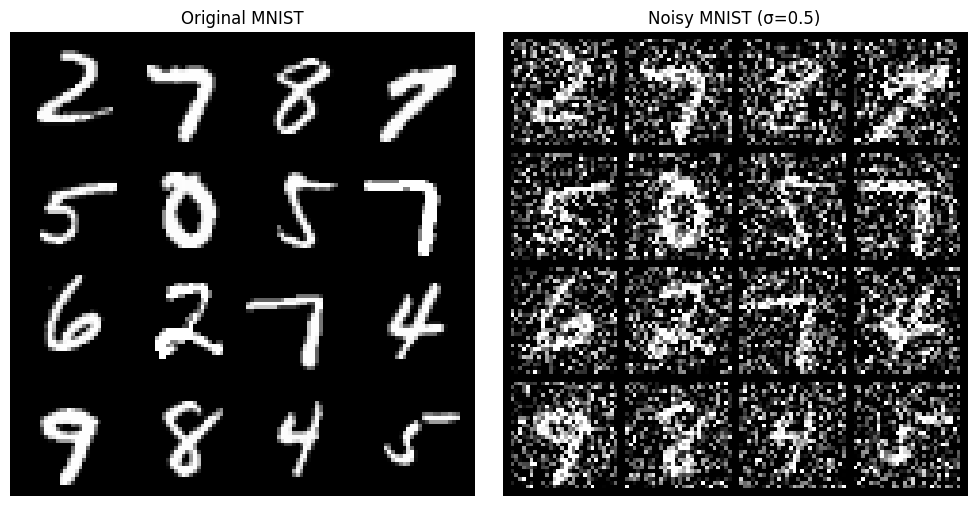

In [ ]:
import torch
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# 1) Noise transform (callable on batched tensors)
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(noisy, 0., 1.)

# 2) Base transform (just ToTensor)
transform = transforms.ToTensor()

# 3) Load MNIST test split
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=16, shuffle=True)

# 4) Fetch a single batch of clean images
images_clean, labels = next(iter(loader))  # shape: [16,1,28,28]

# 5) Apply noise to that same batch
noise_std = 0.5
noise_transform = AddGaussianNoise(0., noise_std)
images_noisy = noise_transform(images_clean)

# 6) Build 4×4 grids
grid_clean = utils.make_grid(images_clean, nrow=4, padding=2)
grid_noisy = utils.make_grid(images_noisy, nrow=4, padding=2)

# 7) Convert to H×W×C for matplotlib
np_clean = grid_clean.permute(1, 2, 0).squeeze().cpu().numpy()
np_noisy = grid_noisy.permute(1, 2, 0).squeeze().cpu().numpy()

# 8) Plot side‑by‑side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np_clean, cmap='gray')
axes[0].set_title('Original MNIST')
axes[0].axis('off')

axes[1].imshow(np_noisy, cmap='gray')
axes[1].set_title(f'Noisy MNIST (σ={noise_std})')
axes[1].axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.07MB/s]



--- MNIST Noisy: Training with Nova ---
Epoch 1/7 - Train Loss: 0.5698, Train Acc: 0.8141, Val Loss: 0.2173, Val Acc: 0.9342
Epoch 2/7 - Train Loss: 0.2251, Train Acc: 0.9288, Val Loss: 0.1706, Val Acc: 0.9464
Epoch 3/7 - Train Loss: 0.1815, Train Acc: 0.9425, Val Loss: 0.1601, Val Acc: 0.9496
Epoch 4/7 - Train Loss: 0.1663, Train Acc: 0.9475, Val Loss: 0.1376, Val Acc: 0.9574
Epoch 5/7 - Train Loss: 0.1568, Train Acc: 0.9509, Val Loss: 0.1347, Val Acc: 0.9558
Epoch 6/7 - Train Loss: 0.1462, Train Acc: 0.9530, Val Loss: 0.1261, Val Acc: 0.9590
Epoch 7/7 - Train Loss: 0.1408, Train Acc: 0.9554, Val Loss: 0.1269, Val Acc: 0.9600

Final Results on MNIST_Noisy: Test Loss: 0.1065, Test Acc: 0.9658, Precision: 0.9656, Recall: 0.9656, F1: 0.9656


--- MNIST Noisy: Training with AdamW ---
Epoch 1/7 - Train Loss: 0.6274, Train Acc: 0.7946, Val Loss: 0.2573, Val Acc: 0.9176
Epoch 2/7 - Train Loss: 0.2414, Train Acc: 0.9229, Val Loss: 0.1978, Val Acc: 0.9354
Epoch 3/7 - Train Loss: 0.2015, Train

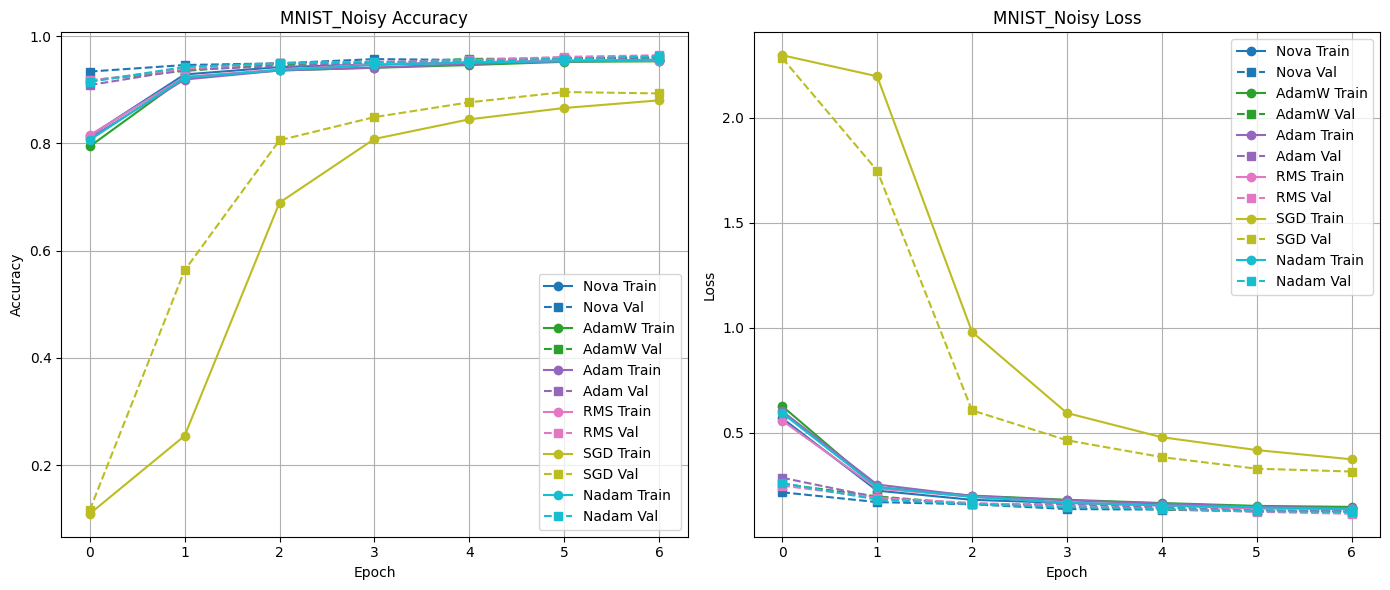

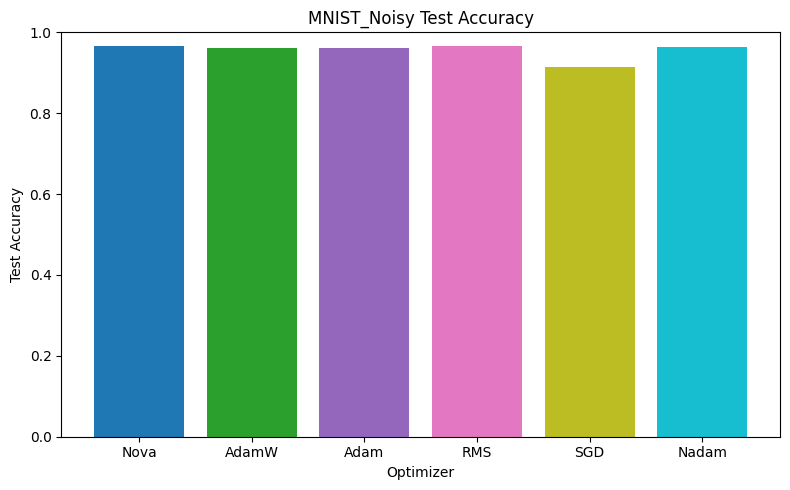

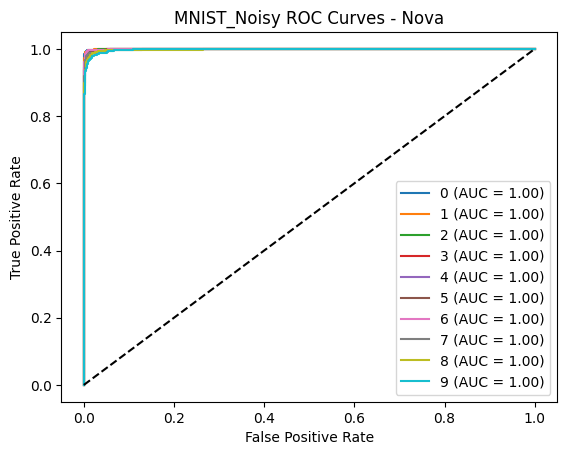

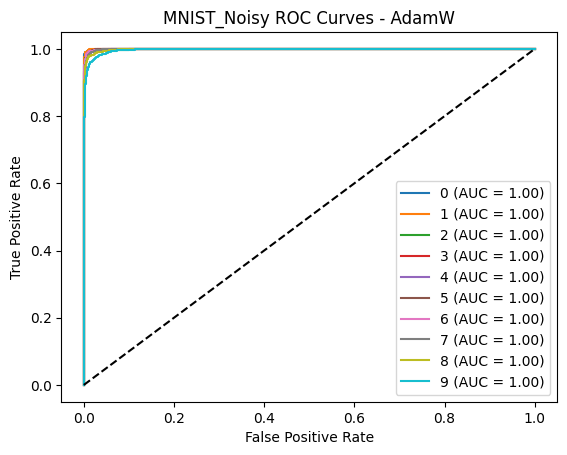

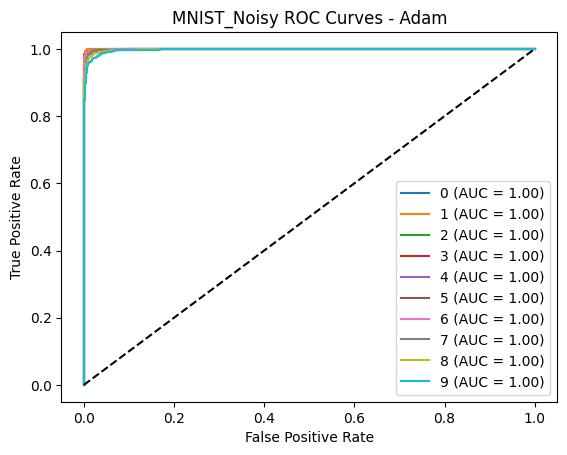

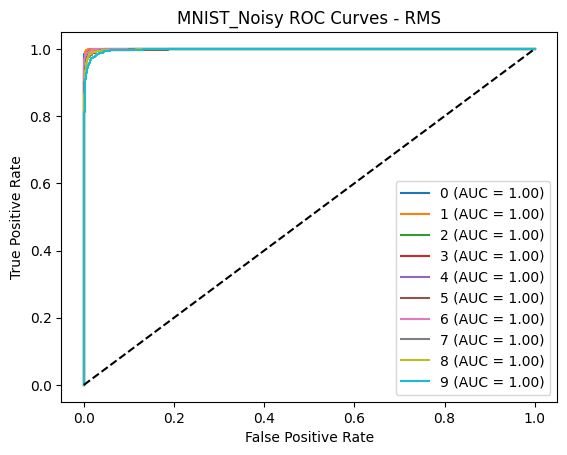

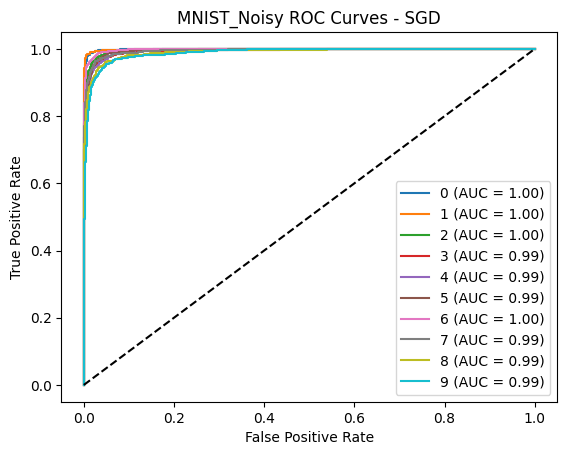

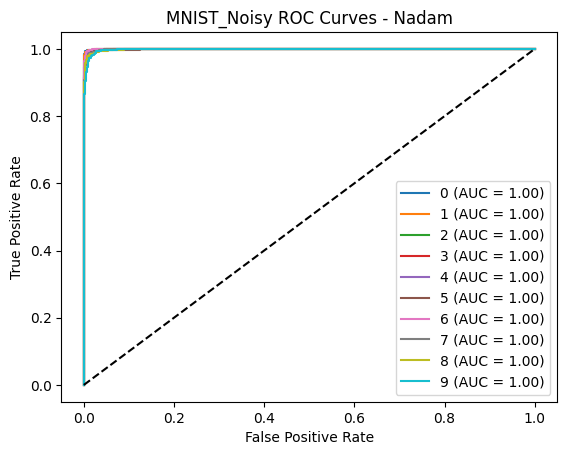

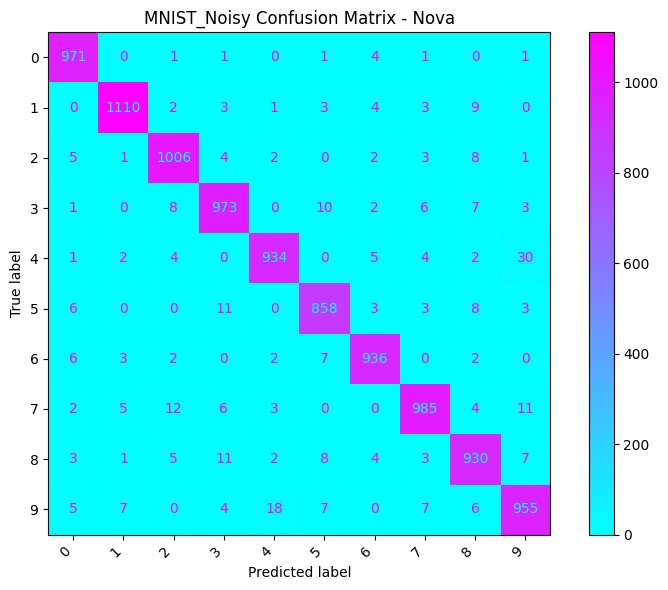

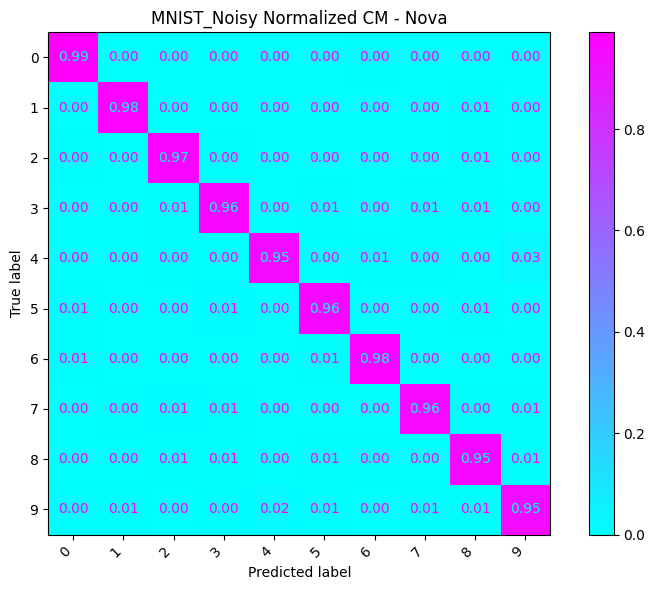

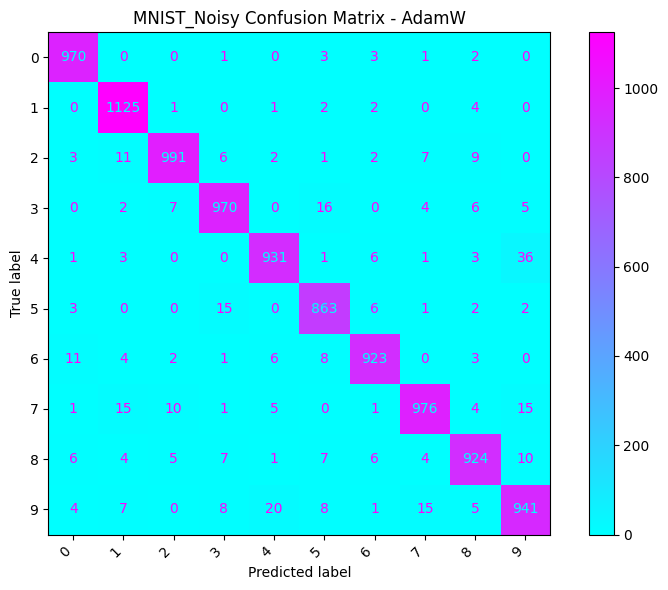

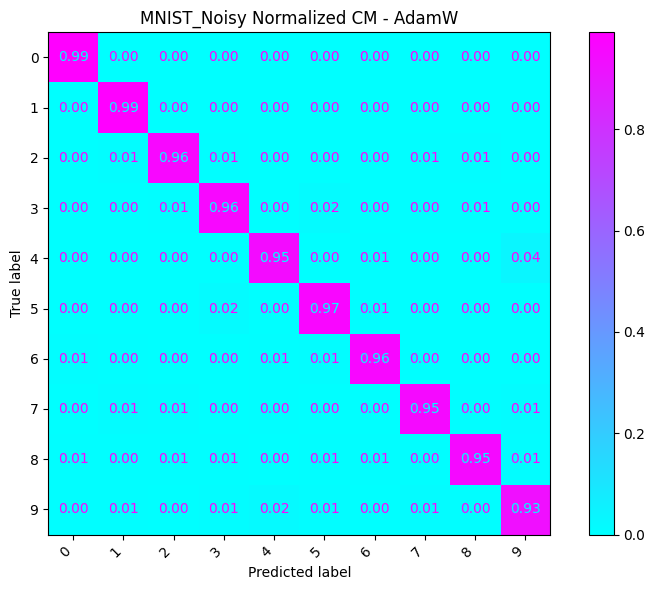

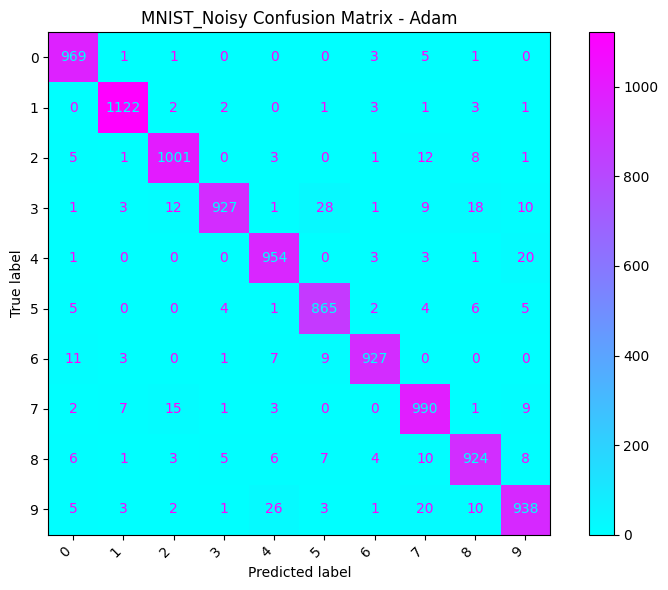

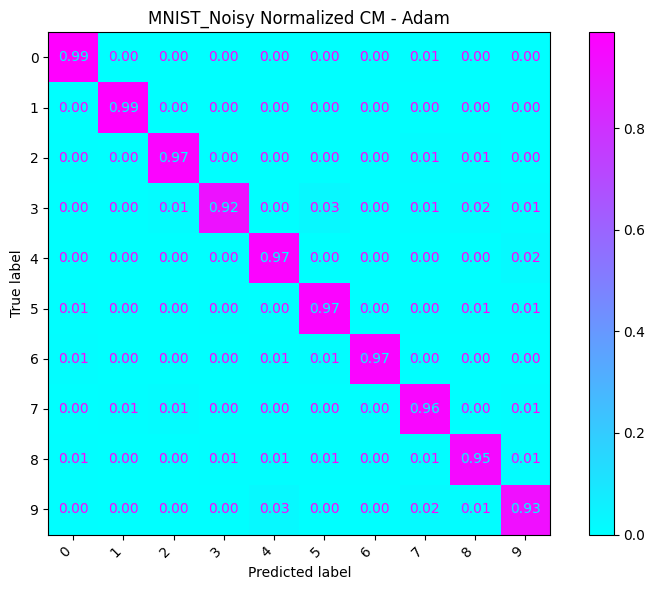

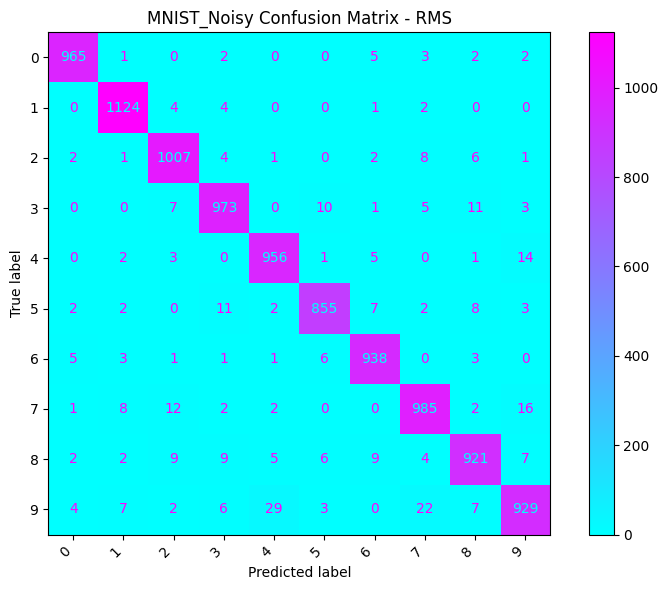

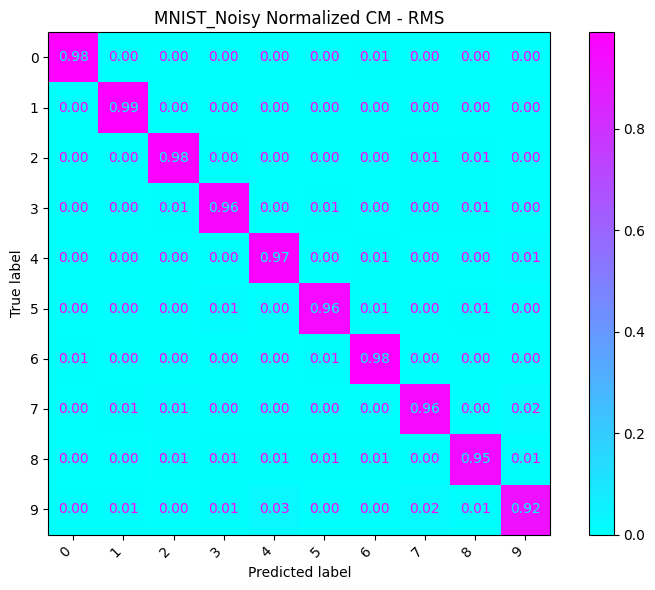

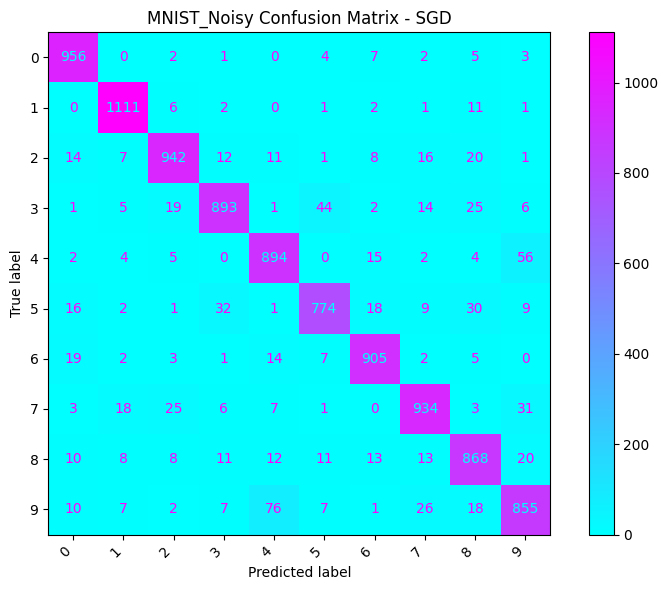

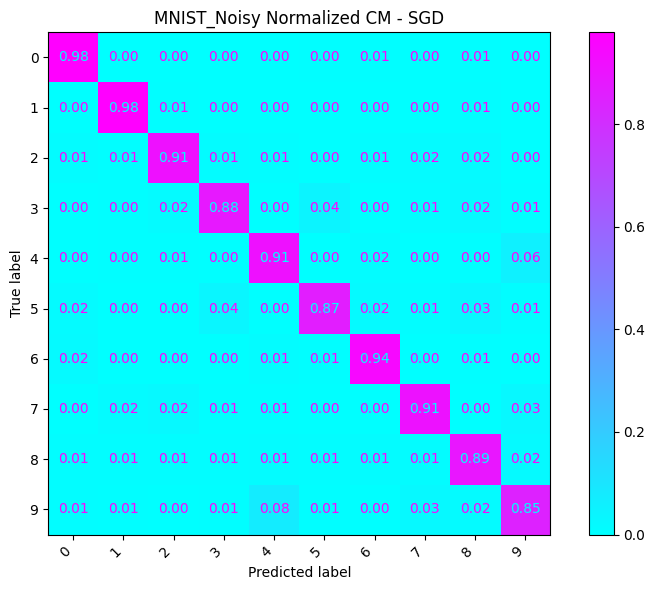

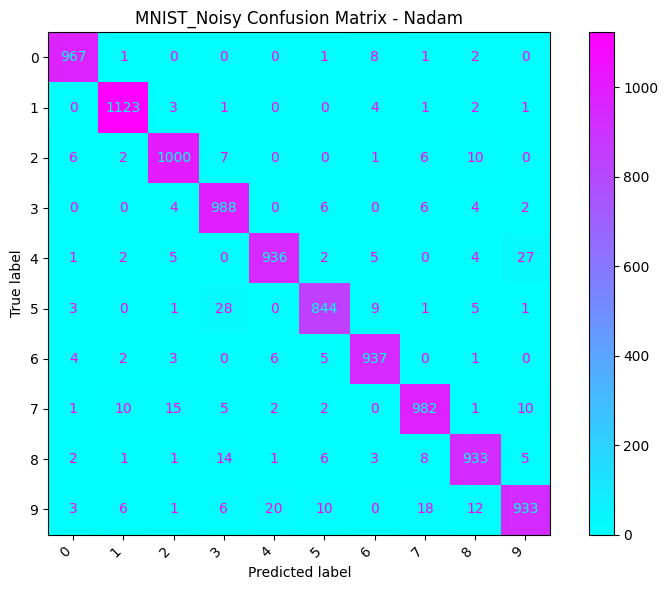

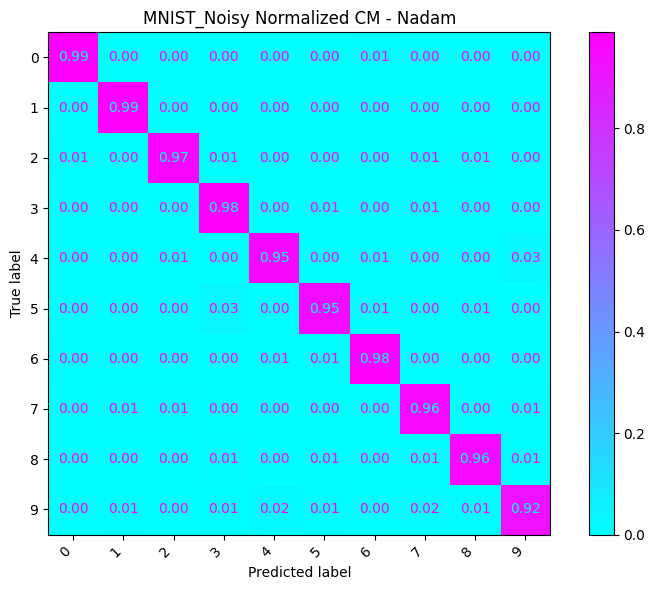

In [ ]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Setup & Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

num_epochs = 7

 #---------------------------
# Nova Optimizer Definition
# ---------------------------
class Nova(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)
        super(Nova, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Nova does not support sparse gradients')

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_max'] = torch.zeros_like(p.data)

                beta1, beta2 = group['betas']
                lr = group['lr']
                weight_decay = group['weight_decay']
                eps = group['eps']

                state['step'] += 1
                t = state['step']

                # Apply weight decay (AdamW-style)
                if weight_decay != 0:
                    p.data.mul_(1 - lr * weight_decay)

                m, v, v_hat_max = state['m'], state['v'], state['v_hat_max']

                # Update first moment
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Nesterov momentum adjustment
                m_nesterov = m * beta1 + grad * (1 - beta1)
                # Bias correction
                m_hat = m_nesterov / (1 - beta1 ** t)

                # Update second moment
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                # Bias correction and track max
                v_hat = v / (1 - beta2 ** t)
                v_hat_max = torch.max(v_hat_max, v_hat)
                state['v_hat_max'] = v_hat_max

                # Parameter update
                denom = v_hat_max.sqrt().add_(eps)
                p.data.addcdiv_(m_hat, denom, value=-lr)
        return loss
# LeNet-5 Model for MNIST
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data Preparation: Noisy MNIST
noise_std = 0.5

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(noisy, 0., 1.)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., noise_std),
    transforms.Normalize((0.1307,), (0.3081,)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., noise_std),
    transforms.Normalize((0.1307,), (0.3081,)),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
train_set, val_set = random_split(mnist_train, [55000, 5000])

train_loader_mnist = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=2)

mnist_class_names = [str(i) for i in range(10)]

# Generic Train Model Function
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader,
                num_epochs=num_epochs, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
        train_loss /= total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, preds = outputs.max(1)
                val_total += targets.size(0)
                val_correct += preds.eq(targets).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # Test evaluation
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            test_correct += preds.eq(targets).sum().item()
            test_total += targets.size(0)
    test_loss /= test_total
    test_acc = test_correct / test_total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    history.update({
        'test_loss': test_loss, 'test_acc': test_acc,
        'precision': precision, 'recall': recall, 'f1': f1,
        'runtime': time.time() - start_time,
        'targets': all_targets, 'probs': all_probs
    })

    print(f"\nFinal Results on {dataset_name}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    return history

# Optimizers
optimizers = {
    'Nova':  lambda p: Nova(p, lr=1e-3, weight_decay=1e-4),
    'AdamW': lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-4),
    'Adam':  lambda p: optim.Adam(p, lr=1e-3, weight_decay=1e-4),
    'RMS':   lambda p: optim.RMSprop(p, lr=1e-3, weight_decay=1e-4),
    'SGD':   lambda p: optim.SGD(p, lr=1e-3, momentum=0.9, weight_decay=1e-4),
    'Nadam': lambda p: optim.NAdam(p, lr=1e-3, weight_decay=1e-4),
}

# Run Experiments for MNIST Noisy
results_mnist_noisy = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST Noisy: Training with {opt_name} ---')
    results_mnist_noisy[opt_name] = train_model(
        LeNet5,
        opt_factory,
        train_loader_mnist,
        val_loader_mnist,
        test_loader_mnist,
        num_epochs=num_epochs,
        dataset_name="MNIST_Noisy"
    )

# Plotting Functions
def plot_learning_curves(results, dataset_name, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    for idx, opt in enumerate(results):
        axes[0].plot(results[opt]['train_acc'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[0].plot(results[opt]['val_acc'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[0].set_title(f'{dataset_name} Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    for idx, opt in enumerate(results):
        axes[1].plot(results[opt]['train_loss'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[1].plot(results[opt]['val_loss'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[1].set_title(f'{dataset_name} Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_learning_curves.png')

def plot_test_accuracy(results, dataset_name):
    final_acc = {opt: results[opt]['test_acc'] for opt in results}
    colors = plt.cm.tab10(np.linspace(0, 1, len(final_acc)))
    plt.figure(figsize=(8, 5))
    plt.bar(final_acc.keys(), final_acc.values(), color=colors)
    plt.ylim(0, 1)
    plt.title(f'{dataset_name} Test Accuracy')
    plt.xlabel('Optimizer')
    plt.ylabel('Test Accuracy')
    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_test_accuracy.png')

def plot_roc_curves(results, dataset_name, class_names):
    for opt in results:
        y_true = label_binarize(results[opt]['targets'], classes=range(len(class_names)))
        y_score = np.array(results[opt]['probs'])
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure()
        for i in range(len(class_names)):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{dataset_name} ROC Curves - {opt}')
        plt.legend()
        # plt.savefig(f'{dataset_name.lower()}_roc_{opt}.png')

def plot_confusion_matrix(cm, class_names, title, normalize=False, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        values_format = '.2f'
    else:
        values_format = 'd'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='cool', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)

# Generate Plots for MNIST Noisy
plot_learning_curves(results_mnist_noisy, "MNIST_Noisy", mnist_class_names)
plot_test_accuracy(results_mnist_noisy, "MNIST_Noisy")
plot_roc_curves(results_mnist_noisy, "MNIST_Noisy", mnist_class_names)
for opt in results_mnist_noisy:
    cm = confusion_matrix(results_mnist_noisy[opt]['targets'], np.argmax(results_mnist_noisy[opt]['probs'], axis=1))
    plot_confusion_matrix(cm, mnist_class_names, f'MNIST_Noisy Confusion Matrix - {opt}', save_path=f'mnist_noisy_cm_{opt}.png')
    plot_confusion_matrix(cm, mnist_class_names, f'MNIST_Noisy Normalized CM - {opt}', normalize=True, save_path=f'mnist_noisy_cm_normalized_{opt}.png')

# LaTeX Table Generation
def generate_latex_table(results, dataset_name):
    table = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        "\\begin{tabular}{lcccccc}\\toprule\n"
        "Optimizer & Test Loss & Test Acc & Precision & Recall & F1 & Epoch Time (s) \\\\ \\midrule\n"
    )
    for opt, m in results.items():
        epoch_time = m['runtime'] / 15  # Assuming 15 epochs
        table += (
            f"{opt} & {m['test_loss']:.4f} & {m['test_acc']:.4f} & "
            f"{m['precision']:.4f} & {m['recall']:.4f} & {m['f1']:.4f} & "
            f"{epoch_time:.2f} \\\\\n"
        )
    table += (
        "\\bottomrule\n"
        "\\end{tabular}\n"
        f"\\caption{{Performance Metrics for {dataset_name}}}\n"
        f"\\label{{tab:{dataset_name.lower()}_perf}}\n"
        "\\end{table}\n"
    )
    return table

# Print LaTeX Table for MNIST Noisy
print("\n=== LaTeX Table for MNIST_Noisy ===\n", generate_latex_table(results_mnist_noisy, "MNIST_Noisy"))

# 3-Different Parameters


--- MNIST: Training with Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01 ---

Training on MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01 for 15 epochs...
Epoch 1 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.3381, Train Acc: 0.8969 | Val Loss: 0.1040, Val Acc: 0.9696 | Time: 12.69 sec
Epoch 2 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.0981, Train Acc: 0.9699 | Val Loss: 0.0866, Val Acc: 0.9760 | Time: 13.01 sec
Epoch 3 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.0729, Train Acc: 0.9776 | Val Loss: 0.0703, Val Acc: 0.9802 | Time: 12.60 sec
Epoch 4 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.0603, Train Acc: 0.9810 | Val Loss: 0.0575, Val Acc: 0.9848 | Time: 12.83 sec
Epoch 5 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.0527, Train Acc: 0.9838 | Val Loss: 0.0531, Val Acc: 0.9834 | Time: 12.88 sec
Epoch 6 (MNIST_Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01) => Train Loss: 0.0458, Train Acc: 0.9857 | Val Loss: 0.0468

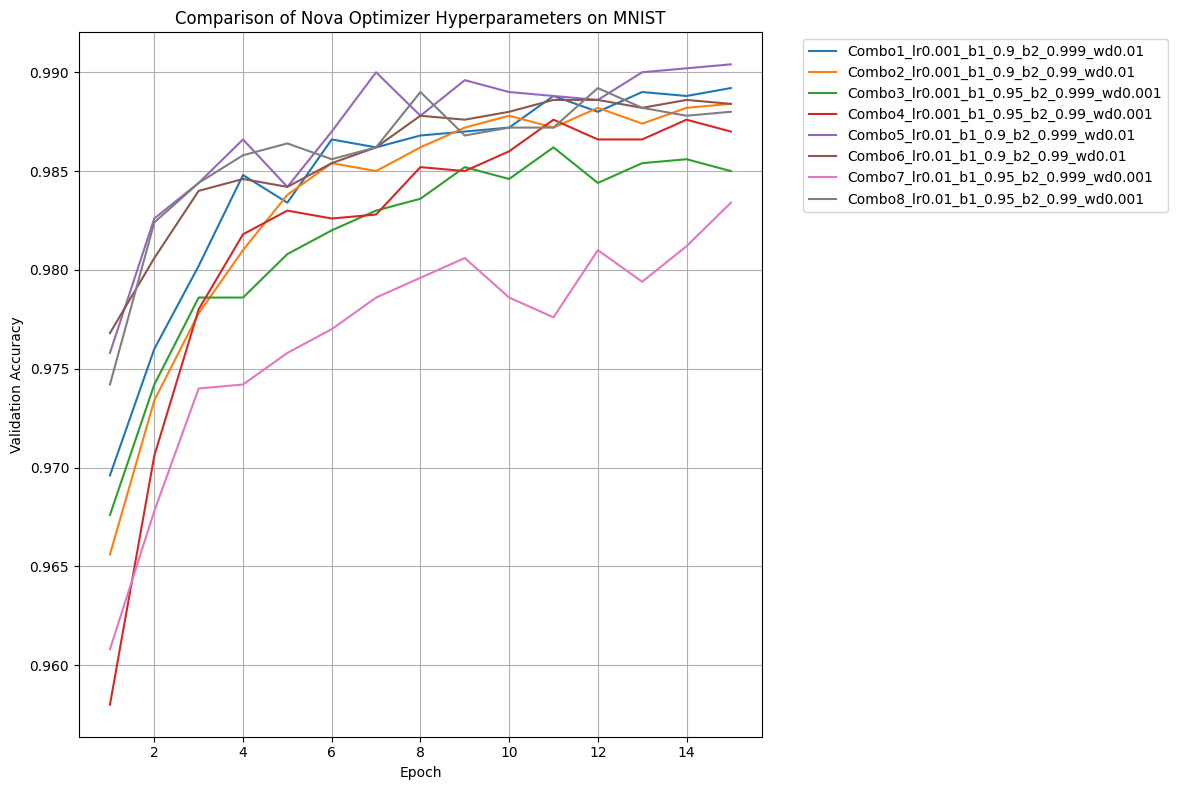

In [ ]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Reproducibility: Seed Initialization
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

epochs = 15

# Custom Nova Optimizer
class Nova(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)
        super(Nova, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Nova does not support sparse gradients')

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_max'] = torch.zeros_like(p.data)

                beta1, beta2 = group['betas']
                lr = group['lr']
                weight_decay = group['weight_decay']
                eps = group['eps']

                state['step'] += 1
                t = state['step']

                # Apply weight decay (AdamW style)
                if weight_decay != 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)

                m, v, v_hat_max = state['m'], state['v'], state['v_hat_max']

                # Update first moment
                m.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Nesterov momentum adjustment
                m_nesterov = m * beta1 + grad * (1 - beta1)

                # Bias correction for m
                m_hat = m_nesterov / (1 - beta1 ** t)

                # Update second moment
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction for v and track max
                v_hat = v / (1 - beta2 ** t)
                v_hat_max = torch.max(v_hat_max, v_hat)
                state['v_hat_max'] = v_hat_max

                # Update parameters
                denom = v_hat_max.sqrt().add_(eps)
                p.data.addcdiv_(m_hat, denom, value=-lr)

        return loss

# MNIST: LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data Preparation for MNIST
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_size_mnist, val_size_mnist = 55000, 5000
trainset_mnist, valset_mnist = random_split(trainset_mnist, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(trainset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(valset_mnist, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(testset_mnist, batch_size=128, shuffle=False, num_workers=2)

# Training Function
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader, num_epochs=3, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    overall_start_time = time.time()

    metrics = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'test_loss': 0.0, 'test_acc': 0.0,
        'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0,
        'probs': [], 'targets': [],
        'total_time': 0.0
    }

    print(f"\nTraining on {dataset_name} for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        metrics['val_loss'].append(epoch_val_loss)
        metrics['val_acc'].append(epoch_val_acc)

        writer.add_scalar(f"{dataset_name}/Train Loss", epoch_train_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Train Accuracy", epoch_train_acc, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Loss", epoch_val_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Accuracy", epoch_val_acc, epoch)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} ({dataset_name}) => Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | Time: {epoch_time:.2f} sec")

        scheduler.step()

    total_training_time = time.time() - overall_start_time
    metrics['total_time'] = total_training_time

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    probs, targets_all = [], []
    with torch.no_grad():
        for data, t in test_loader:
            data, t = data.to(device), t.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, t).item()
            _, predicted = outputs.max(1)
            total += t.size(0)
            correct += predicted.eq(t).sum().item()
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            targets_all.extend(t.cpu().numpy())
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_acc'] = correct / total
    metrics['probs'] = np.array(probs)
    metrics['targets'] = np.array(targets_all)

    preds = np.argmax(metrics['probs'], axis=1)
    precision = precision_score(metrics['targets'], preds, average='macro')
    recall = recall_score(metrics['targets'], preds, average='macro')
    accuracy = accuracy_score(metrics['targets'], preds)
    f1 = f1_score(metrics['targets'], preds, average='macro')
    metrics['test_precision'] = precision
    metrics['test_recall'] = recall
    metrics['test_acc'] = accuracy
    metrics['test_f1'] = f1

    print(f"\nFinal Test Results on {dataset_name}:")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}")
    print(f"Total Training Time: {total_training_time:.2f} seconds\n")

    writer.close()
    return metrics, optimizer.defaults['lr'], optimizer.defaults['betas'][0], optimizer.defaults['betas'][1], optimizer.defaults['weight_decay']

# Define 8 Combinations of Hyperparameters for Nova Optimizer
optimizers = {
    'Combo1_lr0.001_b1_0.9_b2_0.999_wd0.01': lambda params: Nova(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01),
    'Combo2_lr0.001_b1_0.9_b2_0.99_wd0.01': lambda params: Nova(params, lr=0.001, betas=(0.9, 0.99), weight_decay=0.01),
    'Combo3_lr0.001_b1_0.95_b2_0.999_wd0.001': lambda params: Nova(params, lr=0.001, betas=(0.95, 0.999), weight_decay=0.001),
    'Combo4_lr0.001_b1_0.95_b2_0.99_wd0.001': lambda params: Nova(params, lr=0.001, betas=(0.95, 0.99), weight_decay=0.001),
    'Combo5_lr0.01_b1_0.9_b2_0.999_wd0.01': lambda params: Nova(params, lr=0.01, betas=(0.9, 0.999), weight_decay=0.01),
    'Combo6_lr0.01_b1_0.9_b2_0.99_wd0.01': lambda params: Nova(params, lr=0.01, betas=(0.9, 0.99), weight_decay=0.01),
    'Combo7_lr0.01_b1_0.95_b2_0.999_wd0.001': lambda params: Nova(params, lr=0.01, betas=(0.95, 0.999), weight_decay=0.001),
    'Combo8_lr0.01_b1_0.95_b2_0.99_wd0.001': lambda params: Nova(params, lr=0.01, betas=(0.95, 0.99), weight_decay=0.001),
}

# Run Experiments for MNIST (LeNet-5)
results_mnist = {}
hyperparameters = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST: Training with {opt_name} ---')
    metrics, lr, beta1, beta2, wd = train_model(
        LeNet5, opt_factory,
        train_loader_mnist, val_loader_mnist, test_loader_mnist,
        num_epochs=epochs, dataset_name=f"MNIST_{opt_name}"
    )
    results_mnist[opt_name] = metrics
    hyperparameters[opt_name] = (lr, beta1, beta2, wd)

# Plot Validation Accuracy for All Combinations
plt.figure(figsize=(12, 8))
for opt_name, metrics in results_mnist.items():
    plt.plot(range(1, epochs + 1), metrics['val_acc'], label=opt_name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Nova Optimizer Hyperparameters on MNIST')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('nova_mnist_comparison.png', dpi=300)

# Generate LaTeX Table
latex_table = """
\\begin{table}[h]
\\centering
\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\\hline
\\textbf{Combination} & \\textbf{LR} & \\textbf{$\\beta_1$} & \\textbf{$\\beta_2$} & \\textbf{WD} & \\textbf{Test Acc} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1-Score} \\\\
\\hline
"""
for opt_name, metrics in results_mnist.items():
    lr, beta1, beta2, wd = hyperparameters[opt_name]
    test_acc = metrics['test_acc']
    precision = metrics['test_precision']
    recall = metrics['test_recall']
    f1 = metrics['test_f1']
    # Simplify combination name for table readability
    short_name = opt_name.split('_')[0]
    latex_table += f"{short_name} & {lr} & {beta1} & {beta2} & {wd} & {test_acc:.4f} & {precision:.4f} & {recall:.4f} & {f1:.4f} \\\\\n\\hline\n"

latex_table += """
\\end{tabular}
\\caption{Performance of Nova Optimizer Hyperparameter Combinations on MNIST}
\\label{tab:nova_mnist}
\\end{table}
"""

print("\nLaTeX Table Code:\n")
print(latex_table)

# CIFAR10 and MNIST

In [ ]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# ---------------------------
# Reproducibility: Seed Initialization
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

epochs = 15

# ---------------------------
# Custom Nova Optimizer
# ---------------------------
class Nova(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)
        super(Nova, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Nova does not support sparse gradients')

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_max'] = torch.zeros_like(p.data)

                beta1, beta2 = group['betas']
                lr = group['lr']
                weight_decay = group['weight_decay']
                eps = group['eps']

                state['step'] += 1
                t = state['step']

                # Apply weight decay (AdamW style) with updated add_ syntax
                if weight_decay != 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)

                m, v, v_hat_max = state['m'], state['v'], state['v_hat_max']

                # Update first moment
                m.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Nesterov momentum adjustment
                m_nesterov = m * beta1 + grad * (1 - beta1)

                # Bias correction for m
                m_hat = m_nesterov / (1 - beta1 ** t)

                # Update second moment
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction for v and track max
                v_hat = v / (1 - beta2 ** t)
                v_hat_max = torch.max(v_hat_max, v_hat)
                state['v_hat_max'] = v_hat_max

                # Update parameters
                denom = v_hat_max.sqrt().add_(eps)
                p.data.addcdiv_(m_hat, denom, value=-lr)

        return loss

# ---------------------------
# CIFAR-10: ResNet-18 Model (adapted)
# ---------------------------
class CIFAR10_ResNet(nn.Module):
    def __init__(self):
        super(CIFAR10_ResNet, self).__init__()
        # Use weights=None to avoid deprecated 'pretrained' argument
        self.model = models.resnet18(weights=None)
        # Adapt first convolution for CIFAR-10 (3 channels, 32x32)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove initial max-pooling
        self.model.fc = nn.Linear(512, 10)    # Adjust final layer for 10 classes

    def forward(self, x):
        return self.model(x)

# ---------------------------
# MNIST: LeNet-5 Model
# ---------------------------
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)          # 1 input channel, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)            # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)          # 6 input, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 4 * 4, 120)     # Flattened size: 16*4*4 = 256
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool (output: 6x12x12)
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool (output: 16x4x4)
        x = torch.flatten(x, 1)                   # Flatten to 256 features
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)                           # Output logits (no softmax)
        return x

# ---------------------------
# Data Preparation
# ---------------------------
# CIFAR-10 transforms and datasets
transform_train_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_cifar)
testset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_cifar)
train_size_cifar, val_size_cifar = 45000, 5000
trainset_cifar, valset_cifar = random_split(trainset_cifar, [train_size_cifar, val_size_cifar])
train_loader_cifar = DataLoader(trainset_cifar, batch_size=128, shuffle=True, num_workers=2)
val_loader_cifar = DataLoader(valset_cifar, batch_size=128, shuffle=False, num_workers=2)
test_loader_cifar = DataLoader(testset_cifar, batch_size=128, shuffle=False, num_workers=2)

# MNIST transforms and datasets
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_size_mnist, val_size_mnist = 55000, 5000
trainset_mnist, valset_mnist = random_split(trainset_mnist, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(trainset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(valset_mnist, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(testset_mnist, batch_size=128, shuffle=False, num_workers=2)

# ---------------------------
# Training Function (Generalized)
# ---------------------------
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader, num_epochs=3, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    # Learning Rate Scheduler: reduce LR by 10% every epoch
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    # Record the overall training start time
    overall_start_time = time.time()

    metrics = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'test_loss': 0.0, 'test_acc': 0.0,
        'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0,
        'probs': [], 'targets': [],
        'total_time': 0.0  # Will be set at the end
    }

    print(f"\nTraining on {dataset_name} for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        metrics['val_loss'].append(epoch_val_loss)
        metrics['val_acc'].append(epoch_val_acc)

        # Log metrics to TensorBoard
        writer.add_scalar(f"{dataset_name}/Train Loss", epoch_train_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Train Accuracy", epoch_train_acc, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Loss", epoch_val_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Accuracy", epoch_val_acc, epoch)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} ({dataset_name}) => Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | Time: {epoch_time:.2f} sec")

        # Step the scheduler
        scheduler.step()

    total_training_time = time.time() - overall_start_time
    metrics['total_time'] = total_training_time

    # Test Evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    probs, targets_all = [], []
    with torch.no_grad():
        for data, t in test_loader:
            data, t = data.to(device), t.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, t).item()
            _, predicted = outputs.max(1)
            total += t.size(0)
            correct += predicted.eq(t).sum().item()
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            targets_all.extend(t.cpu().numpy())
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_acc'] = correct / total
    metrics['probs'] = np.array(probs)
    metrics['targets'] = np.array(targets_all)

    # Calculate precision, recall, accuracy, and F1 using sklearn metrics
    preds = np.argmax(metrics['probs'], axis=1)
    precision = precision_score(metrics['targets'], preds, average='macro')
    recall = recall_score(metrics['targets'], preds, average='macro')
    accuracy = accuracy_score(metrics['targets'], preds)
    f1 = f1_score(metrics['targets'], preds, average='macro')
    metrics['test_precision'] = precision
    metrics['test_recall'] = recall
    metrics['test_acc'] = accuracy  # Overwrite with sklearn accuracy
    metrics['test_f1'] = f1

    print(f"\nFinal Test Results on {dataset_name}:")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}")
    print(f"Total Training Time: {total_training_time:.2f} seconds\n")

    writer.close()
    return metrics

# ---------------------------
# Optimizers Setup
# ---------------------------
optimizers = {
    'Nova': lambda params: Nova(params, lr=0.001, weight_decay=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.001, weight_decay=0.01),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.001, weight_decay=0.01),
    'SGD': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.01),
    'Nadam': lambda params: optim.NAdam(params, lr=0.001, weight_decay=0.01)
}


# ---------------------------
# Run Experiments for CIFAR-10 (ResNet-18)
# ---------------------------
results_cifar = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- CIFAR-10: Training with {opt_name} ---')
    results_cifar[opt_name] = train_model(CIFAR10_ResNet, opt_factory,
                                          train_loader_cifar, val_loader_cifar, test_loader_cifar,
                                          num_epochs=epochs, dataset_name="CIFAR-10")

# ---------------------------
# Run Experiments for MNIST (LeNet-5)
# ---------------------------
results_mnist = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST: Training with {opt_name} ---')
    results_mnist[opt_name] = train_model(LeNet5, opt_factory,
                                          train_loader_mnist, val_loader_mnist, test_loader_mnist,
                                          num_epochs=epochs, dataset_name="MNIST")


Files already downloaded and verified
Files already downloaded and verified

--- CIFAR-10: Training with Nova ---

Training on CIFAR-10 for 15 epochs...
Epoch 1 (CIFAR-10) => Train Loss: 1.3592, Train Acc: 0.5054 | Val Loss: 1.2365, Val Acc: 0.5676 | Time: 44.87 sec
Epoch 2 (CIFAR-10) => Train Loss: 0.8826, Train Acc: 0.6852 | Val Loss: 0.9013, Val Acc: 0.6854 | Time: 42.54 sec
Epoch 3 (CIFAR-10) => Train Loss: 0.6931, Train Acc: 0.7590 | Val Loss: 0.7499, Val Acc: 0.7316 | Time: 42.01 sec
Epoch 4 (CIFAR-10) => Train Loss: 0.5877, Train Acc: 0.7962 | Val Loss: 0.6428, Val Acc: 0.7688 | Time: 41.51 sec
Epoch 5 (CIFAR-10) => Train Loss: 0.5089, Train Acc: 0.8219 | Val Loss: 0.5655, Val Acc: 0.7980 | Time: 41.36 sec
Epoch 6 (CIFAR-10) => Train Loss: 0.4538, Train Acc: 0.8420 | Val Loss: 0.4968, Val Acc: 0.8262 | Time: 41.59 sec
Epoch 7 (CIFAR-10) => Train Loss: 0.4023, Train Acc: 0.8595 | Val Loss: 0.4601, Val Acc: 0.8324 | Time: 41.55 sec
Epoch 8 (CIFAR-10) => Train Loss: 0.3626, Train A

# Khodesheh

Style 'seaborn-darkgrid' not available. Falling back to default style.


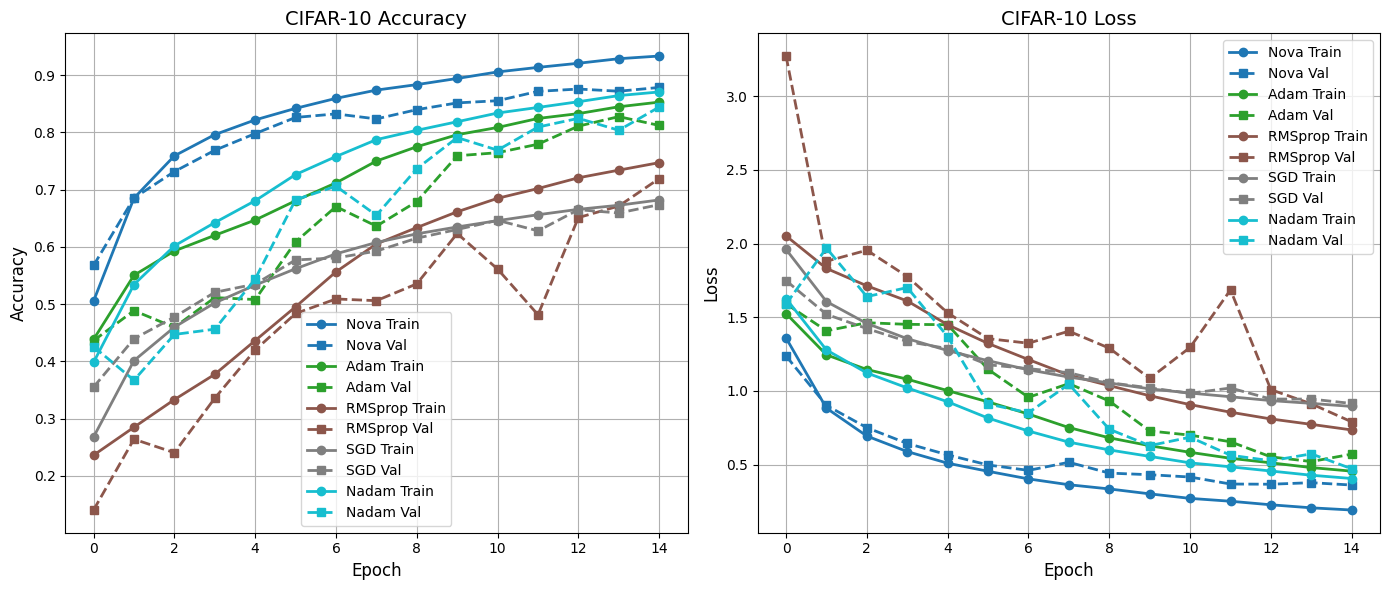

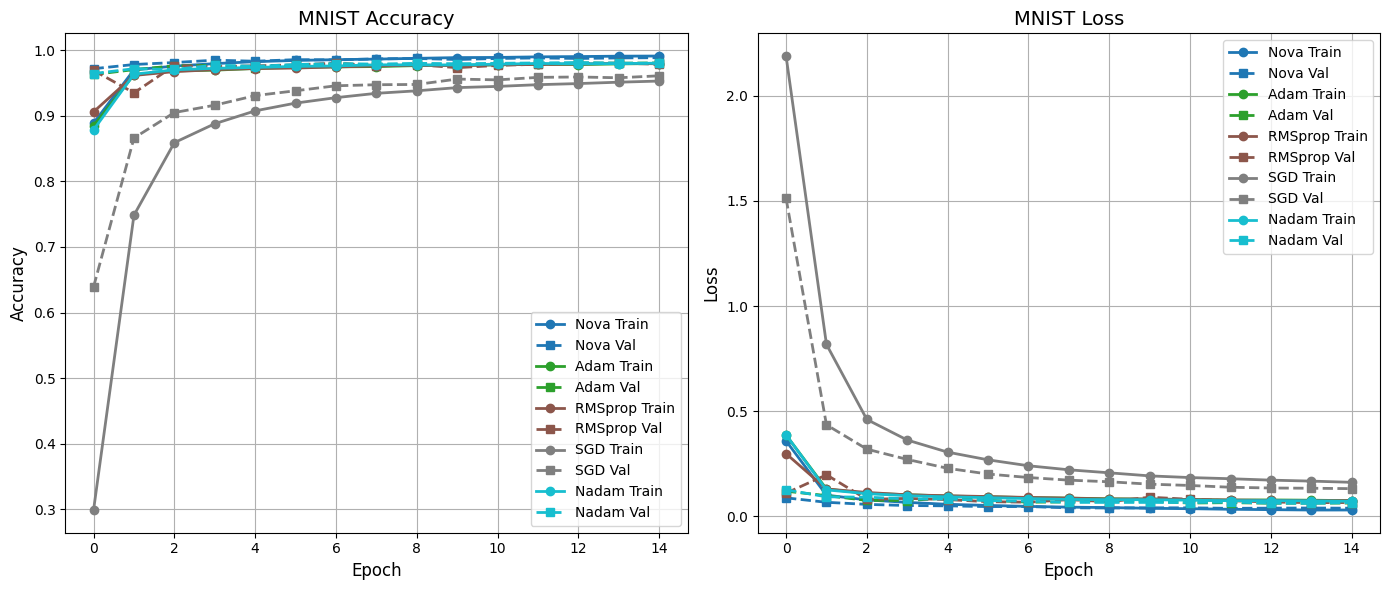

In [ ]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize

# Try to use the 'seaborn-darkgrid' style; if not available, fall back to default.
try:
    plt.style.use('seaborn-darkgrid')
except OSError:
    print("Style 'seaborn-darkgrid' not available. Falling back to default style.")
    plt.style.use('default')

# ---------------------------
# Plotting Learning Curves for CIFAR-10
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Generate distinct colors for each optimizer using the tab10 colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(results_cifar)))

# Accuracy Plot for CIFAR-10
for idx, opt in enumerate(results_cifar):
    axes[0].plot(results_cifar[opt]['train_acc'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_cifar[opt]['val_acc'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('CIFAR-10 Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Loss Plot for CIFAR-10
for idx, opt in enumerate(results_cifar):
    axes[1].plot(results_cifar[opt]['train_loss'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_cifar[opt]['val_loss'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('CIFAR-10 Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# Plotting Learning Curves for MNIST
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Generate distinct colors for each optimizer for MNIST using the tab10 colormap
colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(results_mnist)))

# Accuracy Plot for MNIST
for idx, opt in enumerate(results_mnist):
    axes[0].plot(results_mnist[opt]['train_acc'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_mnist[opt]['val_acc'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('MNIST Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Loss Plot for MNIST
for idx, opt in enumerate(results_mnist):
    axes[1].plot(results_mnist[opt]['train_loss'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_mnist[opt]['val_loss'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('MNIST Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()


Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Neither 'seaborn-darkgrid' nor 'seaborn' are available. Using default style.


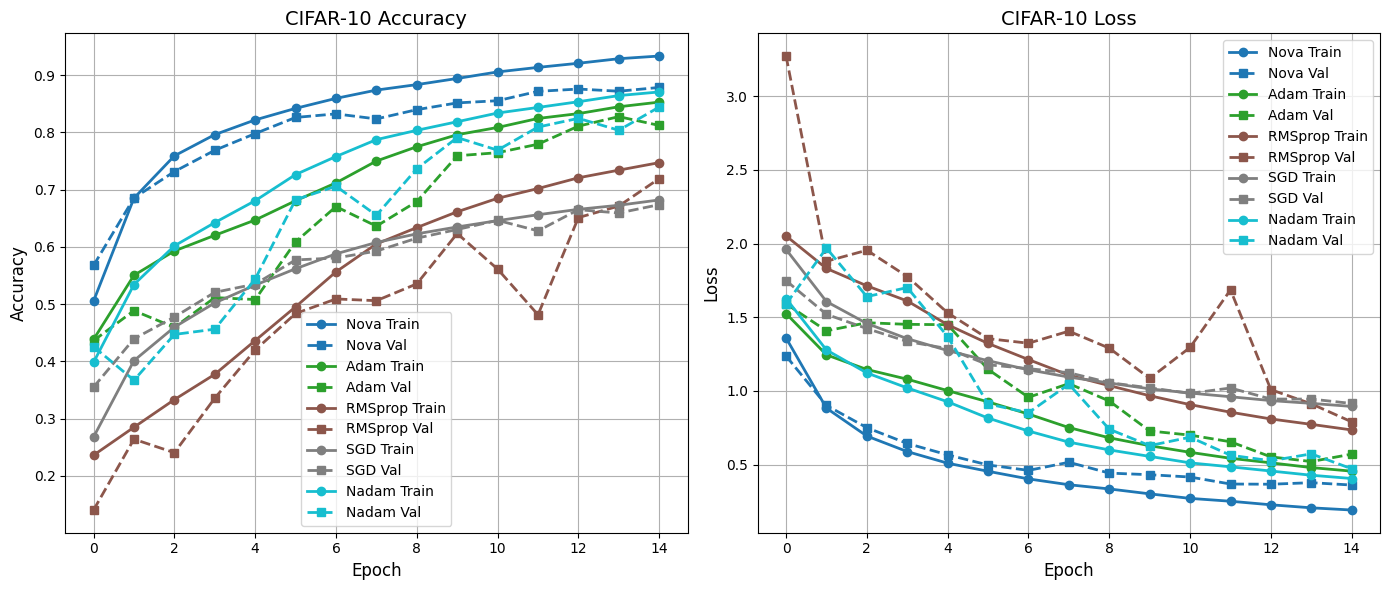

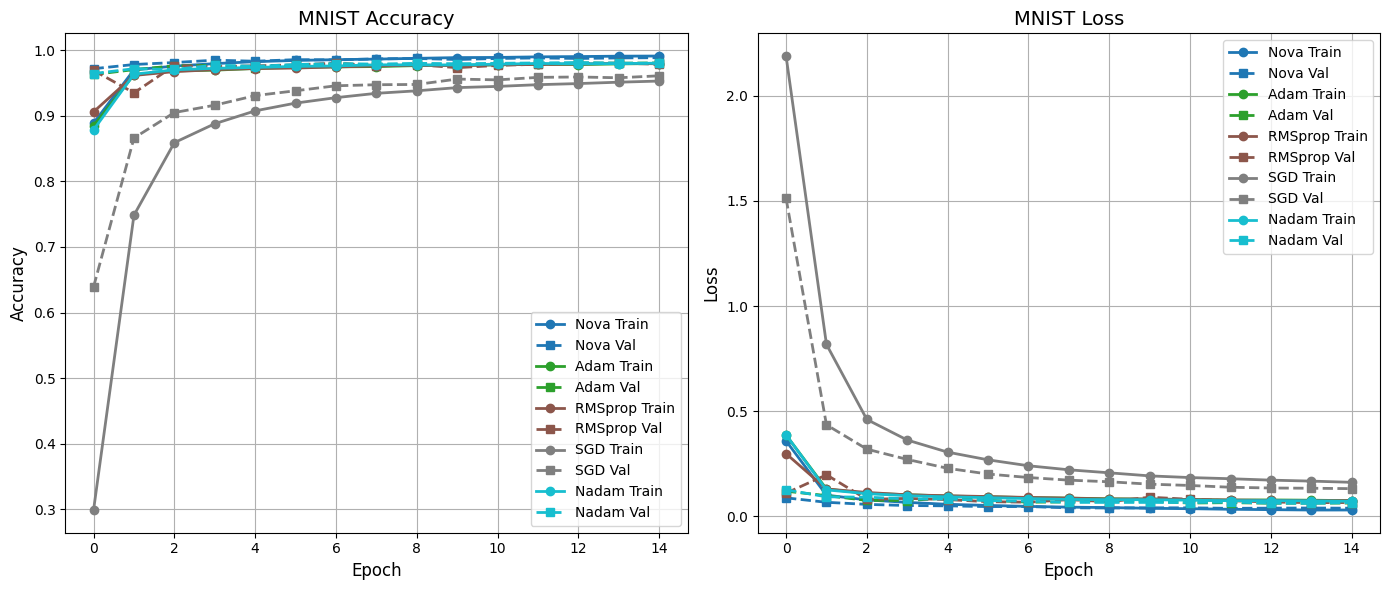

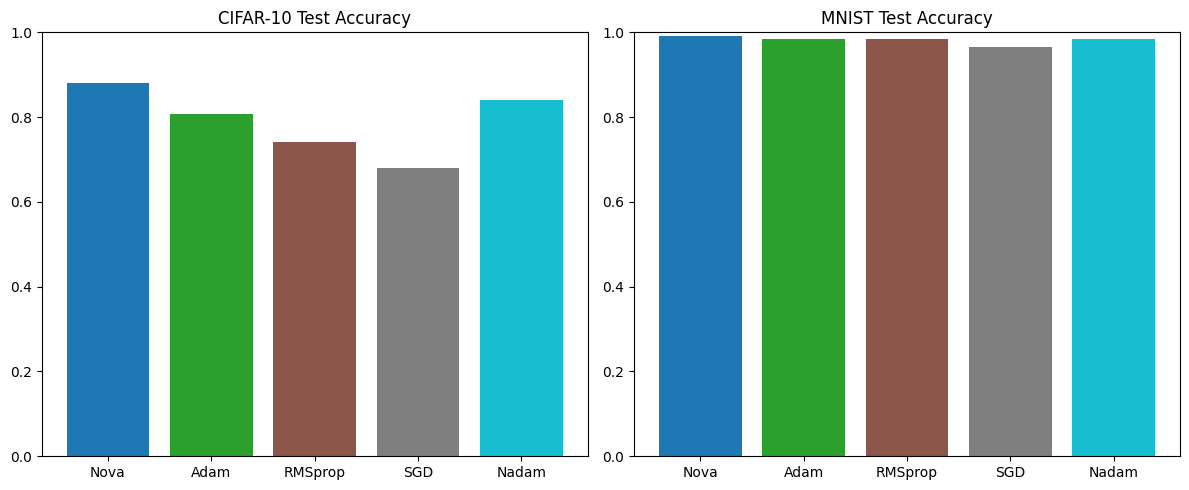

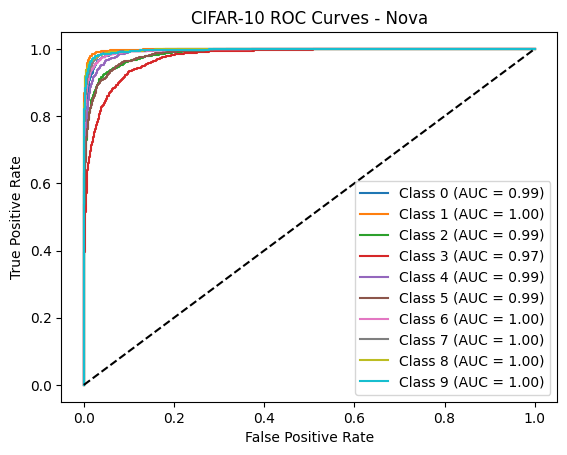

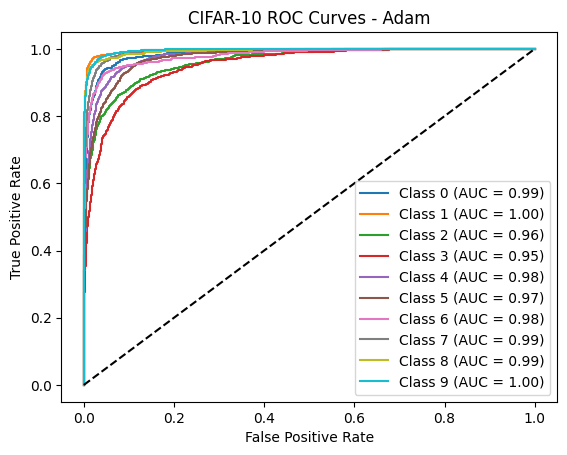

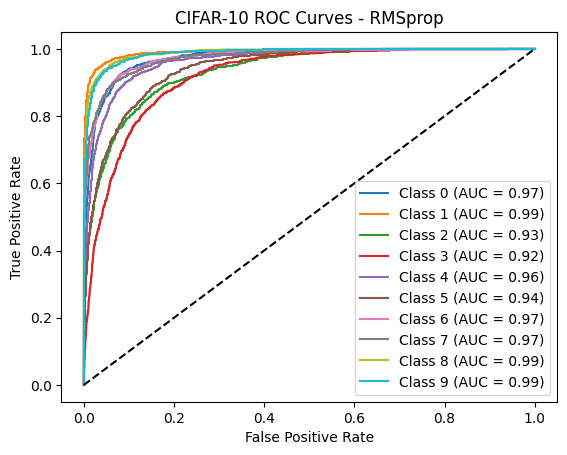

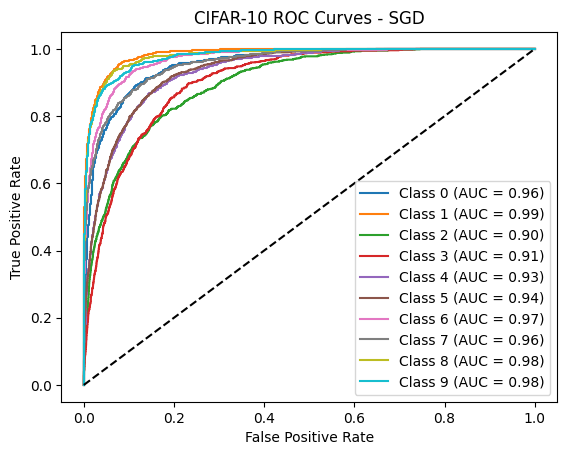

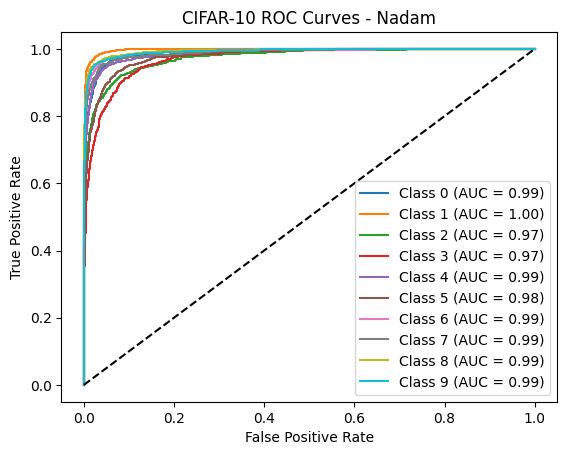

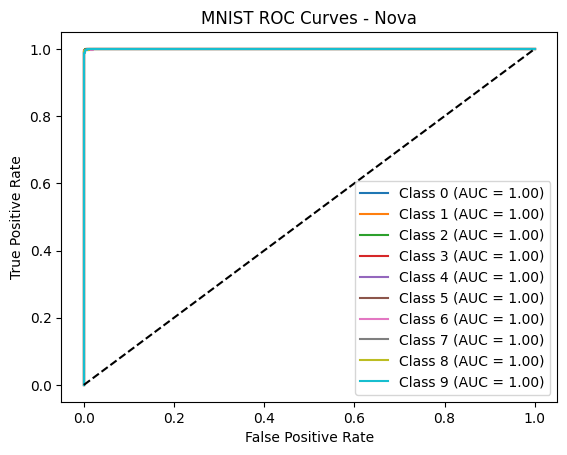

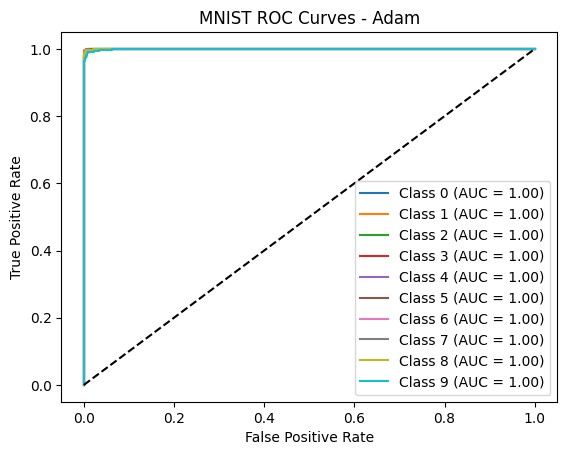

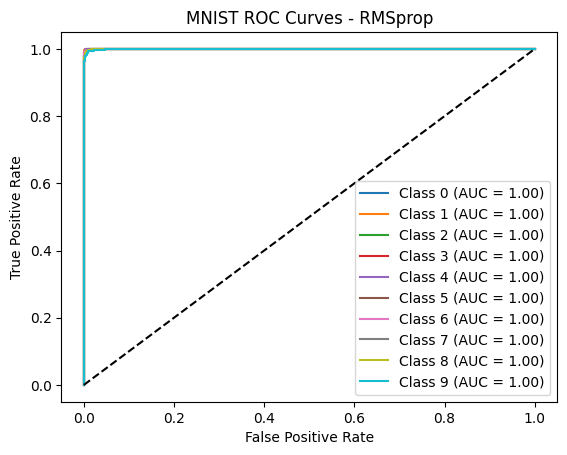

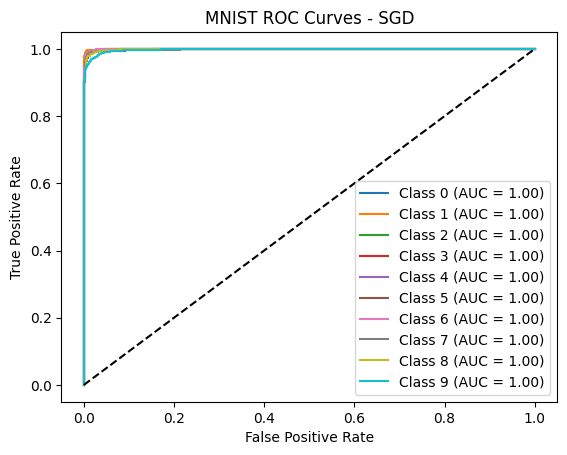

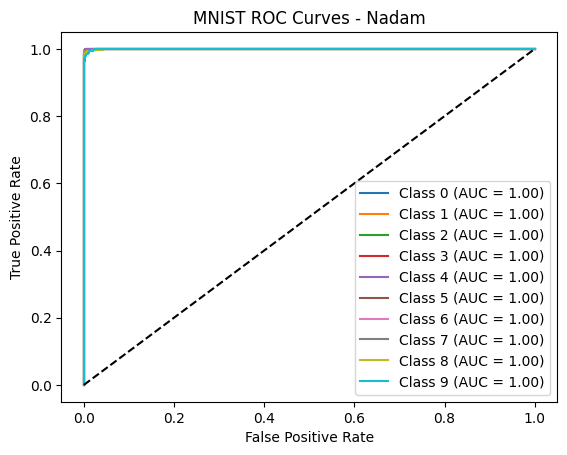

In [ ]:
# # # ---------------------------
# # # Run Experiments for CIFAR-10 (ResNet-18)
# # # ---------------------------
# # results_cifar = {}
# # for opt_name, opt_factory in optimizers.items():
# #     print(f'\n--- CIFAR-10: Training with {opt_name} ---')
# #     results_cifar[opt_name] = train_model(CIFAR10_ResNet, opt_factory,
# #                                           train_loader_cifar, val_loader_cifar, test_loader_cifar,
# #                                           num_epochs=3, dataset_name="CIFAR-10")

# # # ---------------------------
# # # Run Experiments for MNIST (CNN)
# # # ---------------------------
# # results_mnist = {}
# # for opt_name, opt_factory in optimizers.items():
# #     print(f'\n--- MNIST: Training with {opt_name} ---')
# #     results_mnist[opt_name] = train_model(MNIST_CNN, opt_factory,
# #                                           train_loader_mnist, val_loader_mnist, test_loader_mnist,
# #                                           num_epochs=3, dataset_name="MNIST")

# import random
# import time
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms, models
# from torch.utils.data import DataLoader, random_split
# from torch.utils.tensorboard import SummaryWriter
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# from sklearn.metrics import precision_score, recall_score, accuracy_score
# from sklearn.preprocessing import label_binarize

# # Print available styles to check what you can use
# print("Available styles:", plt.style.available)

# # Try to use 'seaborn-darkgrid', if not available try 'seaborn', otherwise default
# if 'seaborn-darkgrid' in plt.style.available:
#     plt.style.use('seaborn-darkgrid')
# elif 'seaborn' in plt.style.available:
#     print("'seaborn-darkgrid' not available; using 'seaborn' instead.")
#     plt.style.use('seaborn')
# else:
#     print("Neither 'seaborn-darkgrid' nor 'seaborn' are available. Using default style.")
#     plt.style.use('default')

# # ---------------------------
# # Plotting Learning Curves for CIFAR-10
# # ---------------------------
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Generate distinct colors for each optimizer using the tab10 colormap
# colors = plt.cm.tab10(np.linspace(0, 1, len(results_cifar)))

# # Accuracy Plot for CIFAR-10
# for idx, opt in enumerate(results_cifar):
#     axes[0].plot(results_cifar[opt]['train_acc'], marker='o',
#                  color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
#     axes[0].plot(results_cifar[opt]['val_acc'], marker='s',
#                  color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
# axes[0].set_title('CIFAR-10 Accuracy', fontsize=14)
# axes[0].set_xlabel('Epoch', fontsize=12)
# axes[0].set_ylabel('Accuracy', fontsize=12)
# axes[0].legend(fontsize=10)
# axes[0].grid(True)

# # Loss Plot for CIFAR-10
# for idx, opt in enumerate(results_cifar):
#     axes[1].plot(results_cifar[opt]['train_loss'], marker='o',
#                  color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
#     axes[1].plot(results_cifar[opt]['val_loss'], marker='s',
#                  color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
# axes[1].set_title('CIFAR-10 Loss', fontsize=14)
# axes[1].set_xlabel('Epoch', fontsize=12)
# axes[1].set_ylabel('Loss', fontsize=12)
# axes[1].legend(fontsize=10)
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()

# # ---------------------------
# # Plotting Learning Curves for MNIST
# # ---------------------------
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Generate distinct colors for each optimizer for MNIST using the tab10 colormap
# colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(results_mnist)))

# # Accuracy Plot for MNIST
# for idx, opt in enumerate(results_mnist):
#     axes[0].plot(results_mnist[opt]['train_acc'], marker='o',
#                  color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
#     axes[0].plot(results_mnist[opt]['val_acc'], marker='s',
#                  color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
# axes[0].set_title('MNIST Accuracy', fontsize=14)
# axes[0].set_xlabel('Epoch', fontsize=12)
# axes[0].set_ylabel('Accuracy', fontsize=12)
# axes[0].legend(fontsize=10)
# axes[0].grid(True)

# # Loss Plot for MNIST
# for idx, opt in enumerate(results_mnist):
#     axes[1].plot(results_mnist[opt]['train_loss'], marker='o',
#                  color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
#     axes[1].plot(results_mnist[opt]['val_loss'], marker='s',
#                  color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
# axes[1].set_title('MNIST Loss', fontsize=14)
# axes[1].set_xlabel('Epoch', fontsize=12)
# axes[1].set_ylabel('Loss', fontsize=12)
# axes[1].legend(fontsize=10)
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()




# # ---------------------------
# # Final Test Accuracy Bar Plot for CIFAR-10 and MNIST with Distinct Colors
# # ---------------------------
# final_acc_cifar = {opt: results_cifar[opt]['test_acc'] for opt in results_cifar}
# final_acc_mnist = {opt: results_mnist[opt]['test_acc'] for opt in results_mnist}

# # Generate distinct colors for each optimizer using the tab10 colormap
# colors_cifar = plt.cm.tab10(np.linspace(0, 1, len(final_acc_cifar)))
# colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(final_acc_mnist)))

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.bar(final_acc_cifar.keys(), final_acc_cifar.values(), color=colors_cifar)
# plt.ylim(0, 1)
# plt.title('CIFAR-10 Test Accuracy')

# plt.subplot(1, 2, 2)
# plt.bar(final_acc_mnist.keys(), final_acc_mnist.values(), color=colors_mnist)
# plt.ylim(0, 1)
# plt.title('MNIST Test Accuracy')
# plt.tight_layout()
# plt.show()

# # ---------------------------
# # Confusion Matrix and ROC Curves for CIFAR-10
# # ---------------------------
# for opt in results_cifar:
#     # ROC Curves for CIFAR-10
#     y_true = label_binarize(results_cifar[opt]['targets'], classes=range(10))
#     y_score = results_cifar[opt]['probs']
#     fpr, tpr, roc_auc = {}, {}, {}
#     for i in range(10):
#         fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])
#     plt.figure()
#     for i in range(10):
#         plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     # Add axis labels to clarify the rates
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'CIFAR-10 ROC Curves - {opt}')
#     plt.legend()
#     plt.show()

# # ---------------------------
# # Confusion Matrix and ROC Curves for MNIST
# # ---------------------------
# for opt in results_mnist:
#     # ROC Curves for MNIST
#     y_true = label_binarize(results_mnist[opt]['targets'], classes=range(10))
#     y_score = results_mnist[opt]['probs']
#     fpr, tpr, roc_auc = {}, {}, {}
#     for i in range(10):
#         fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])
#     plt.figure()
#     for i in range(10):
#         plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     # Add axis labels to clarify the rates
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'MNIST ROC Curves - {opt}')
#     plt.legend()
#     plt.show()



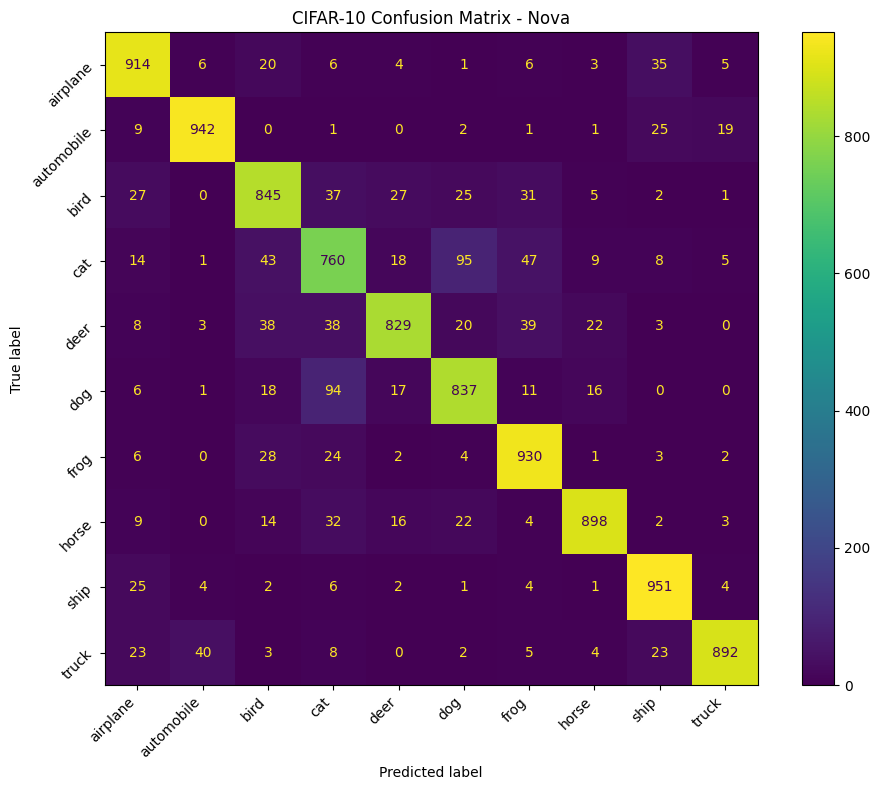

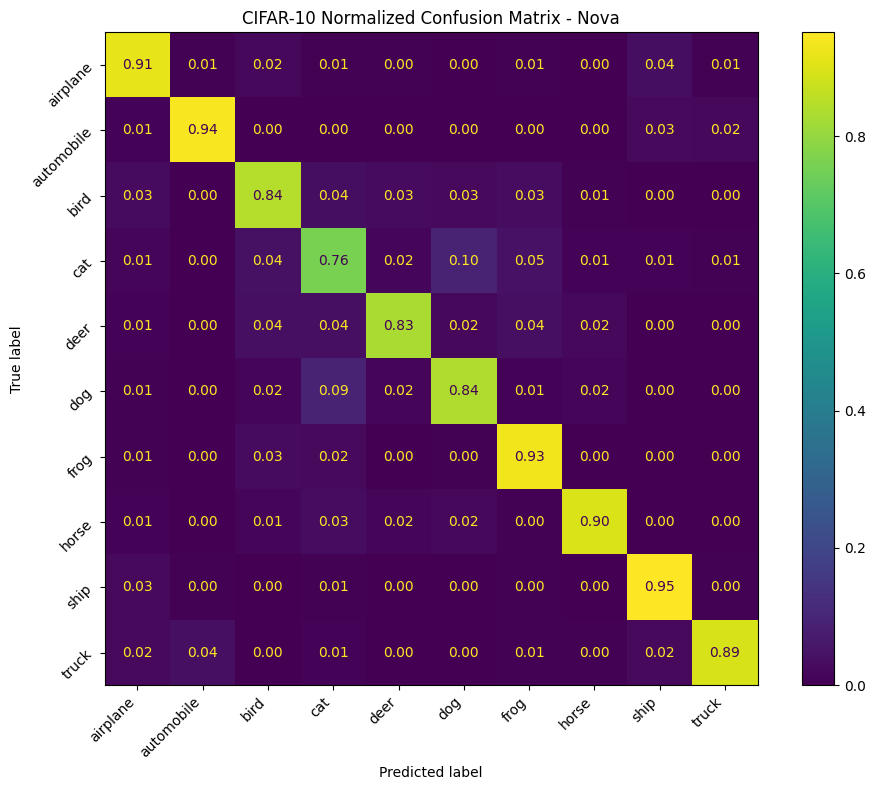

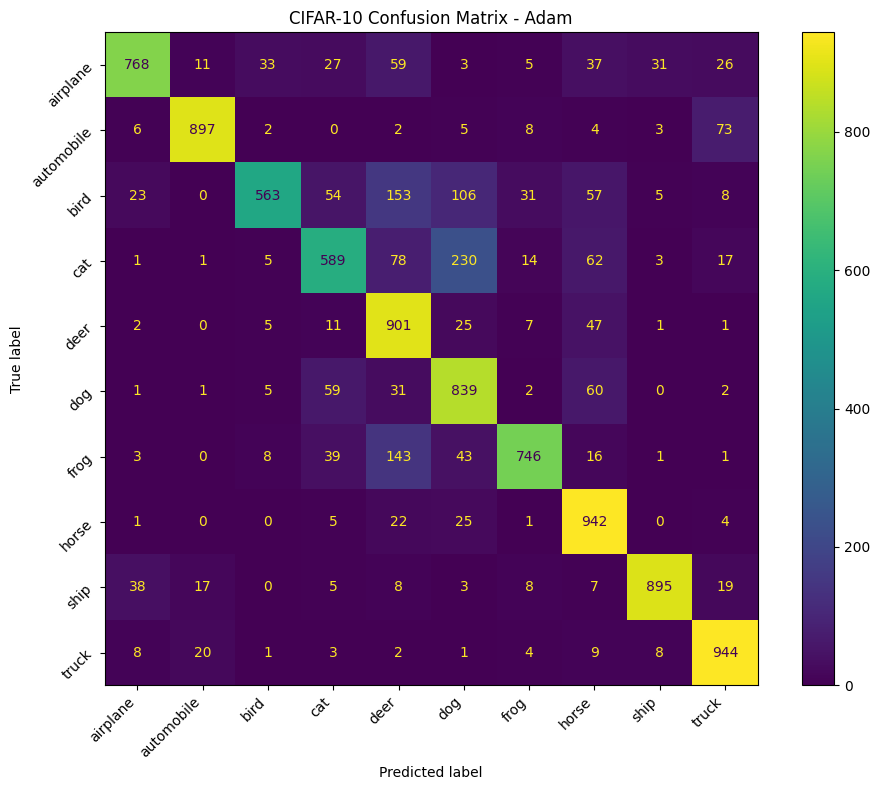

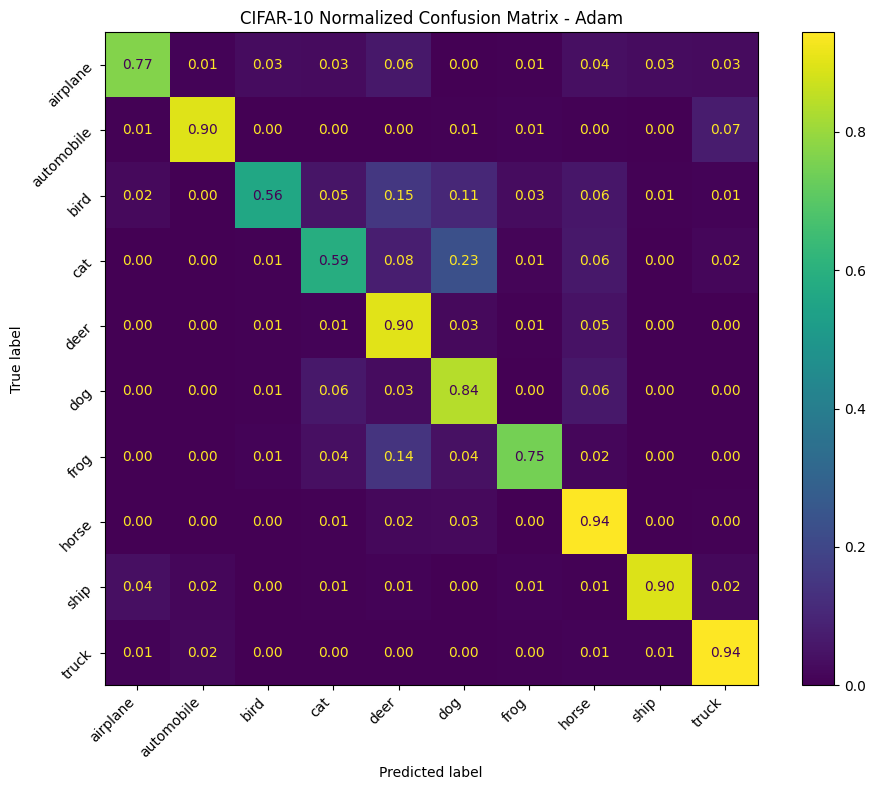

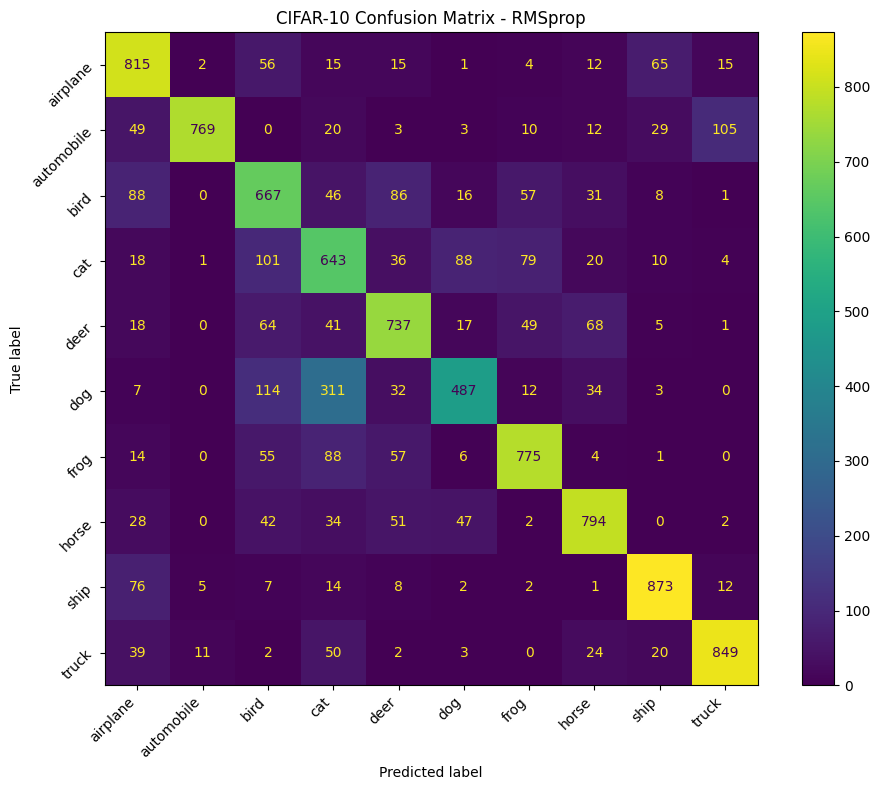

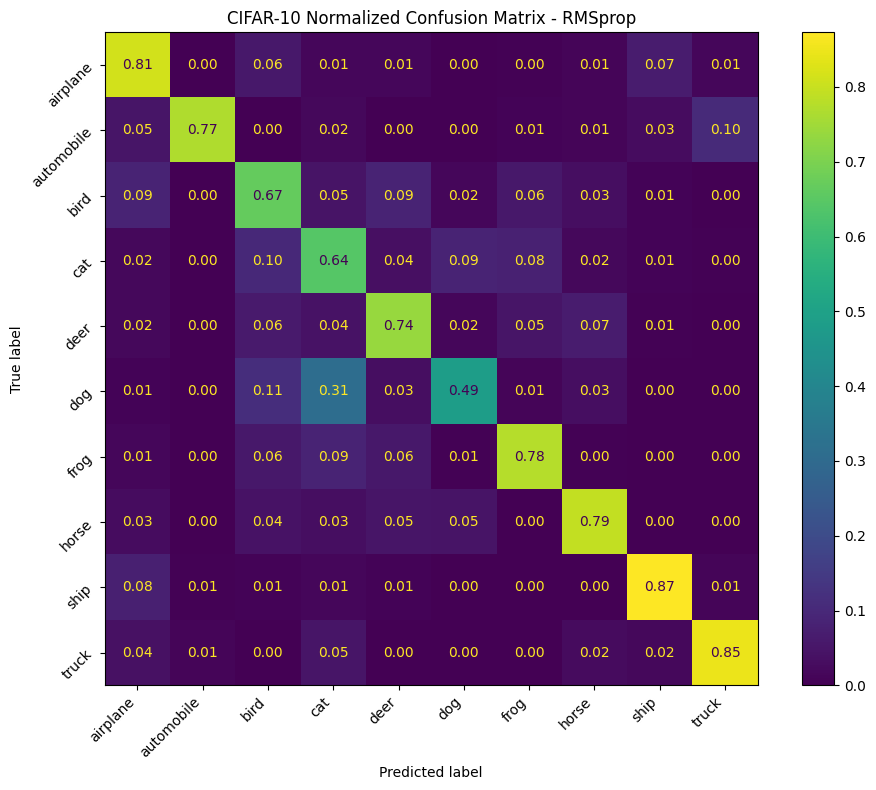

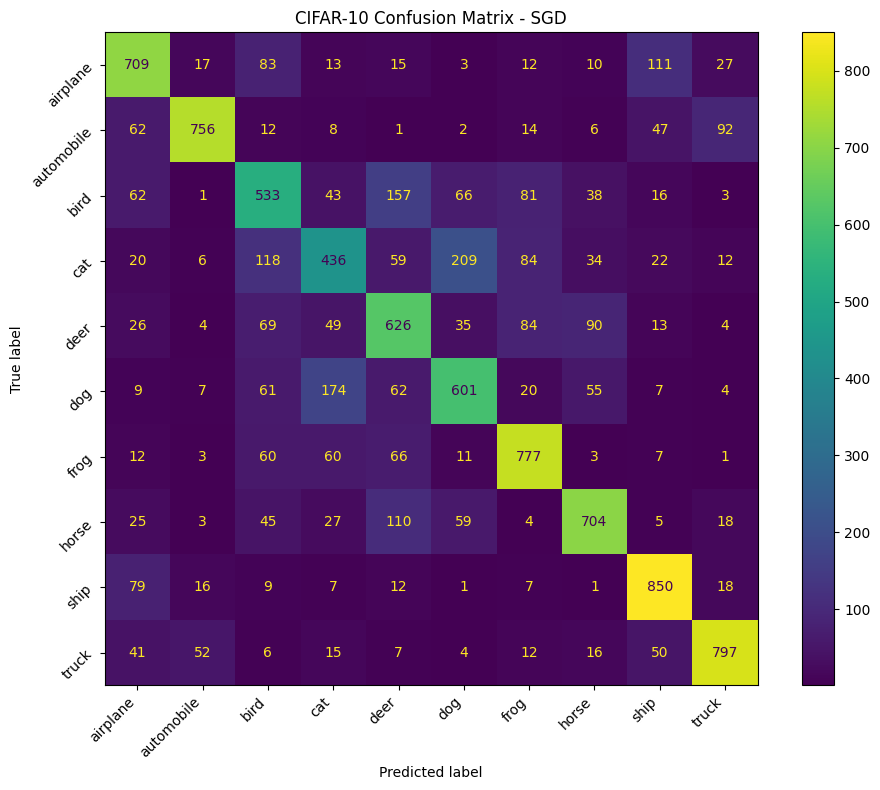

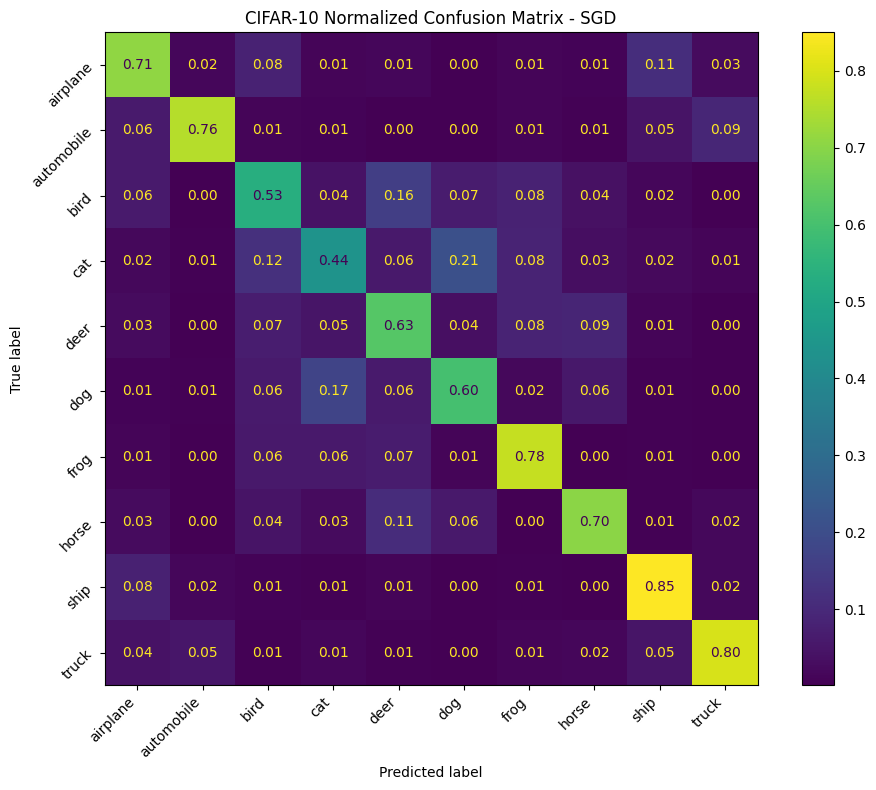

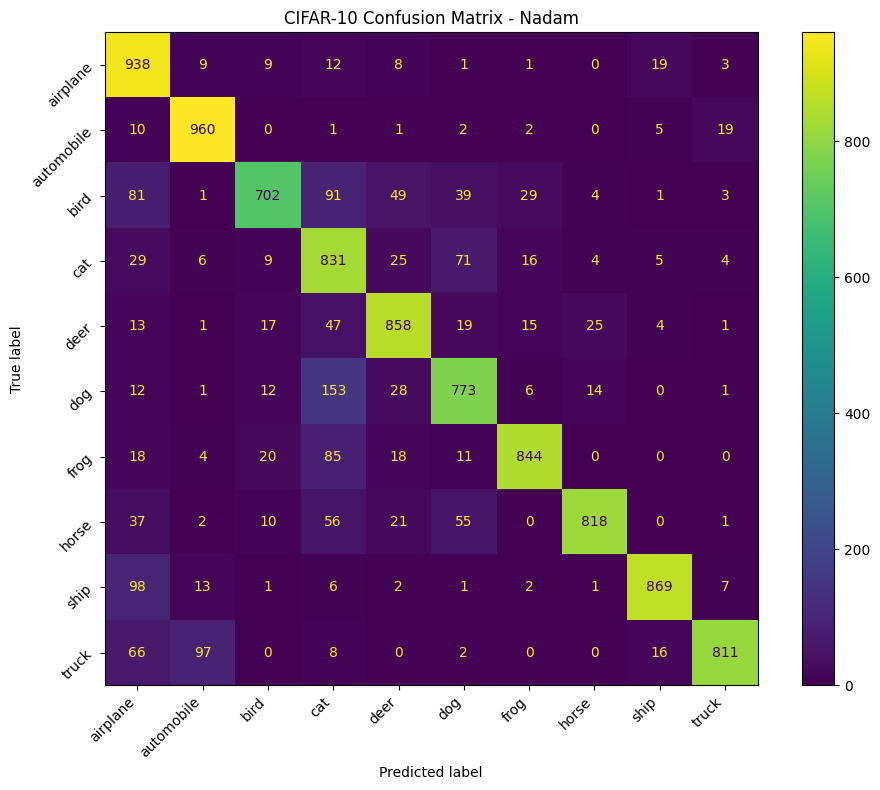

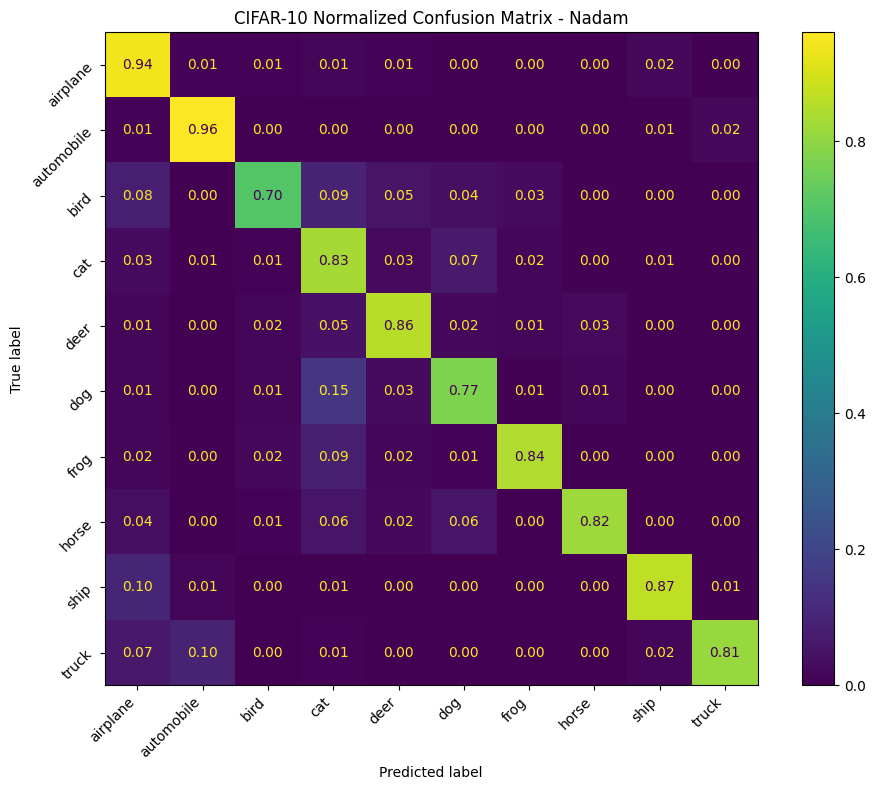

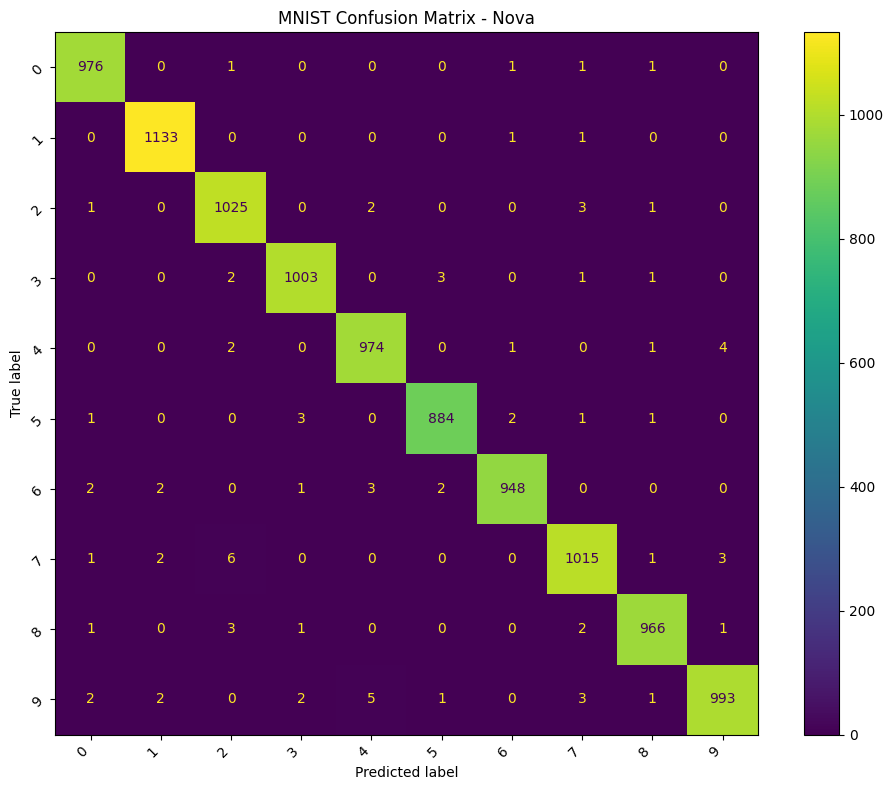

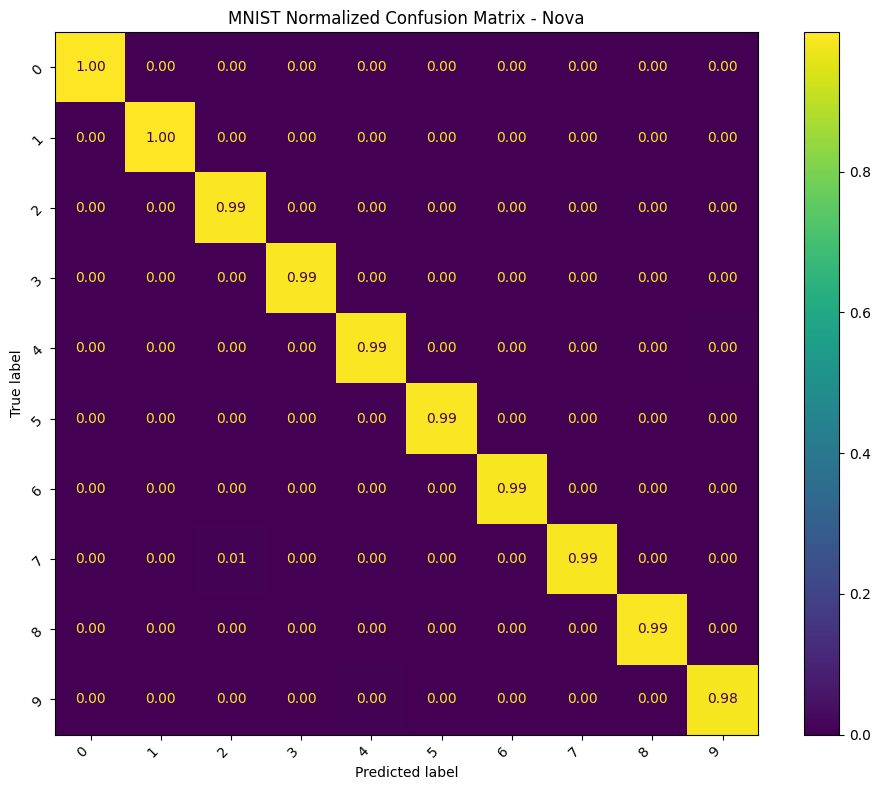

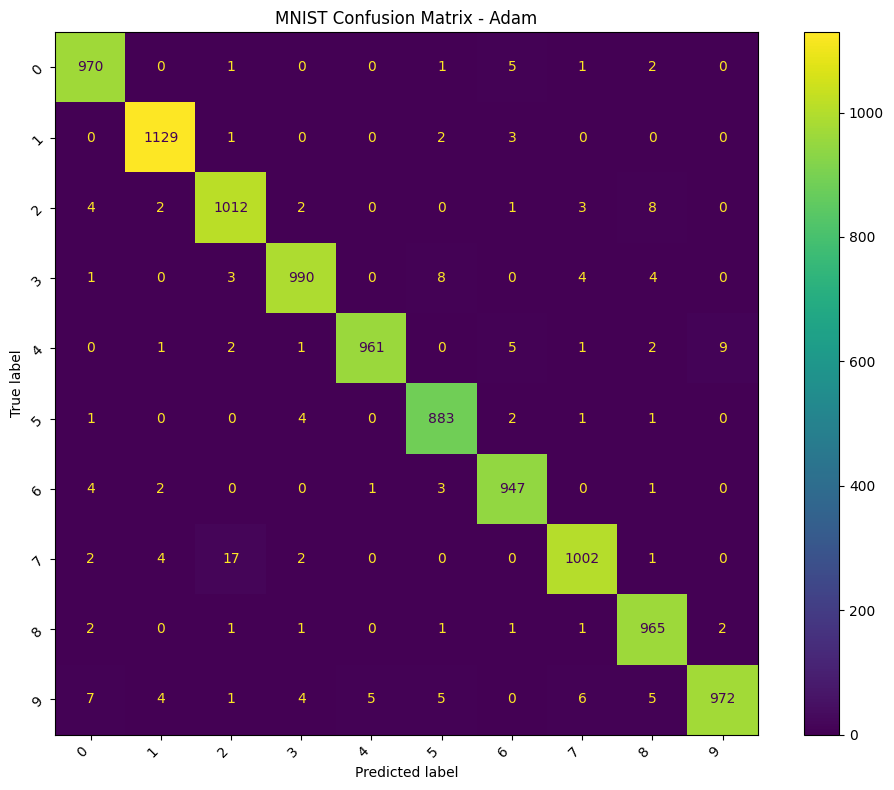

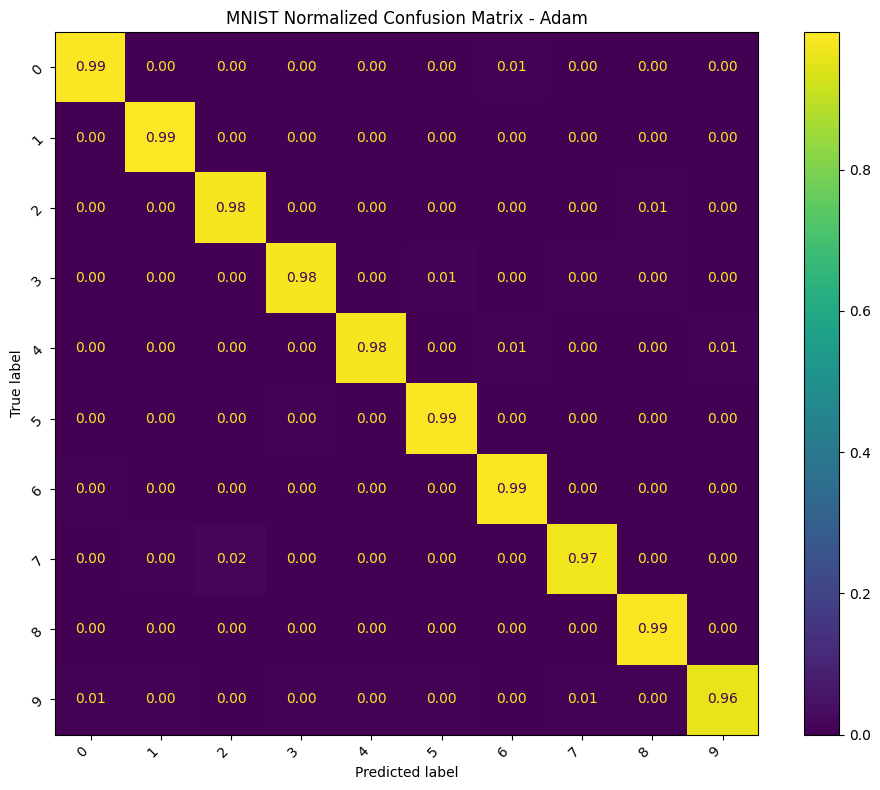

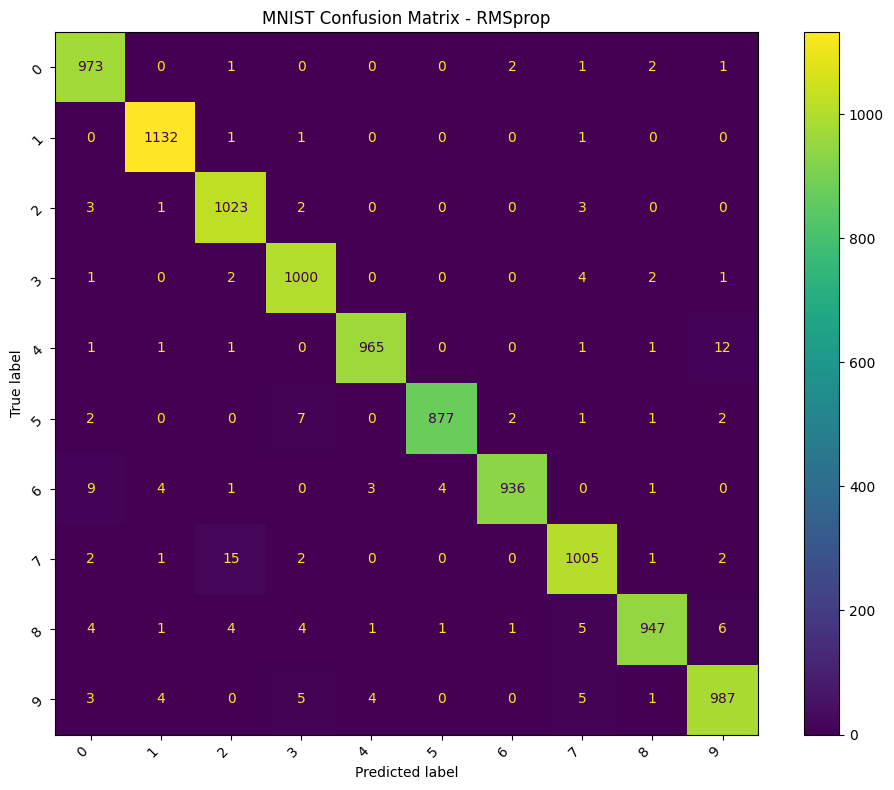

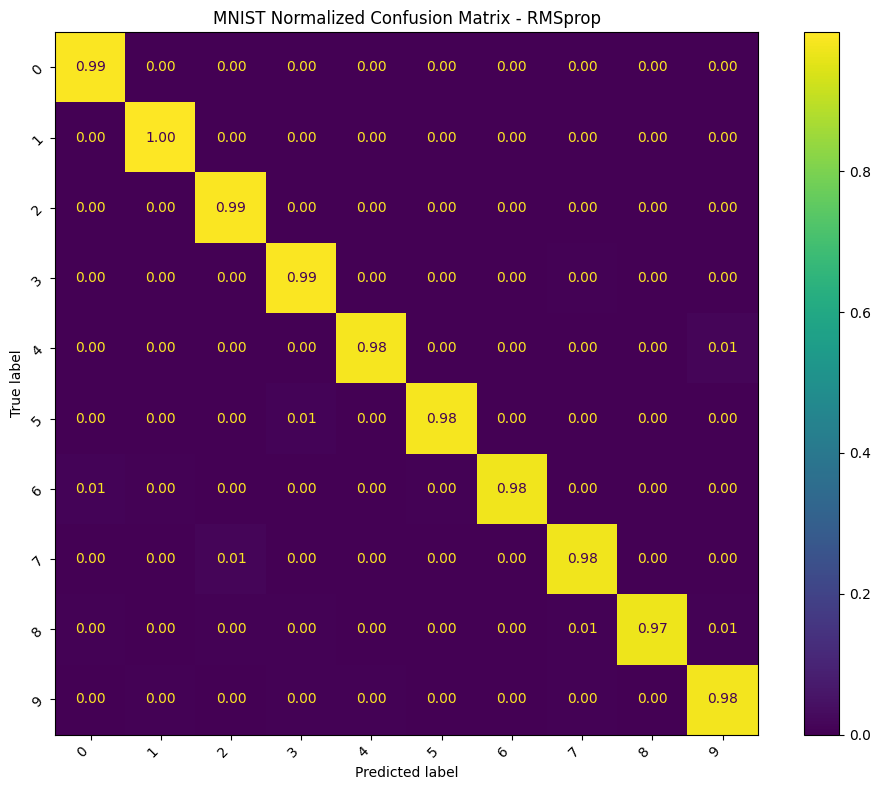

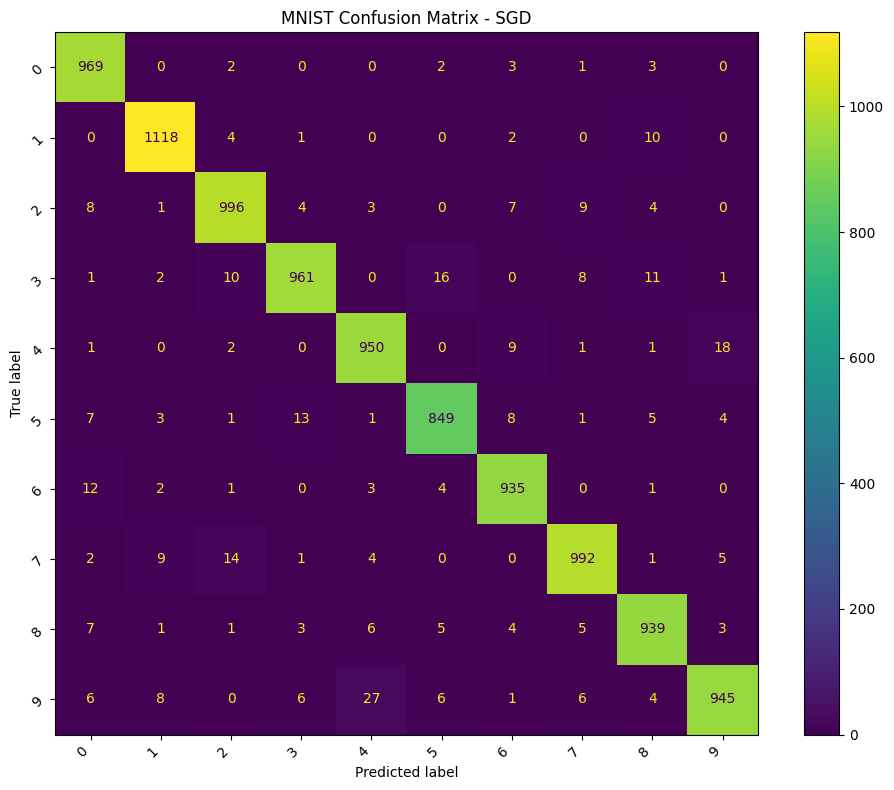

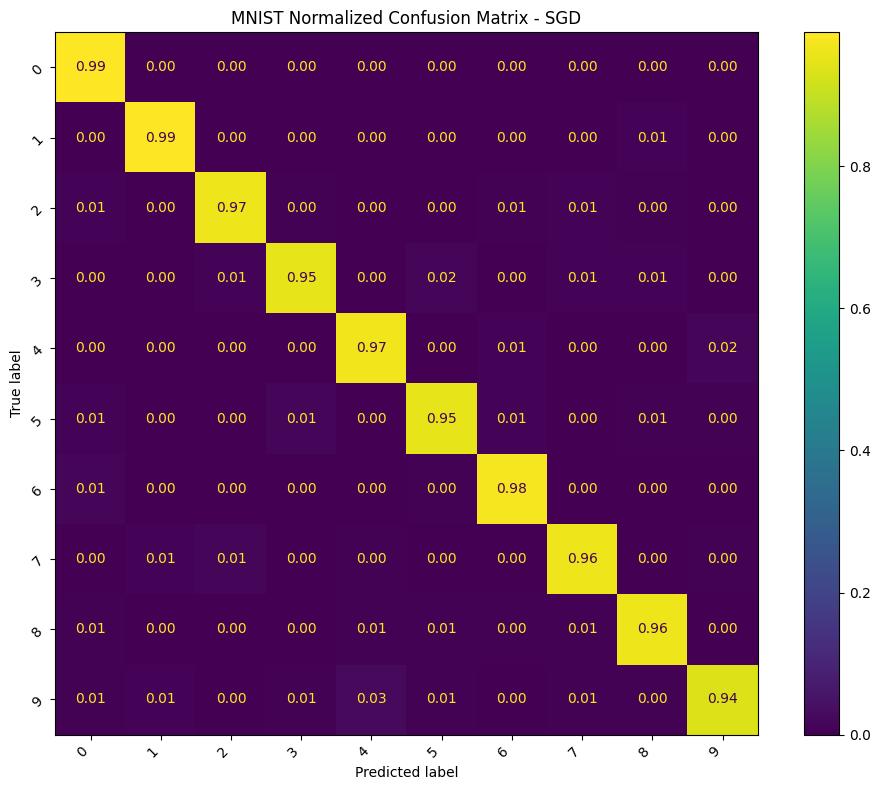

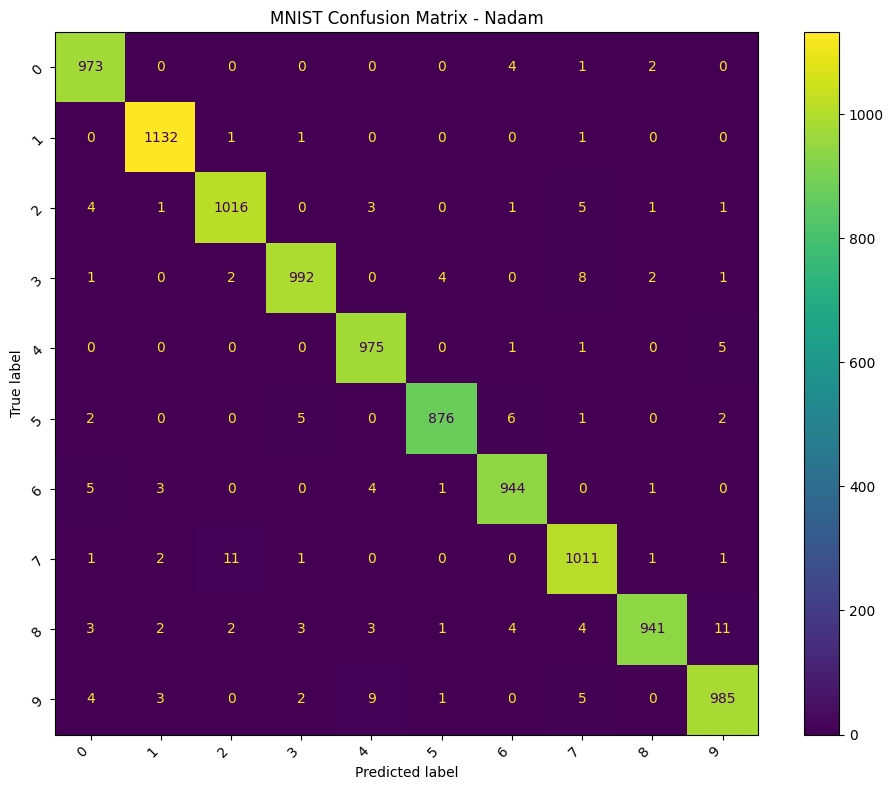

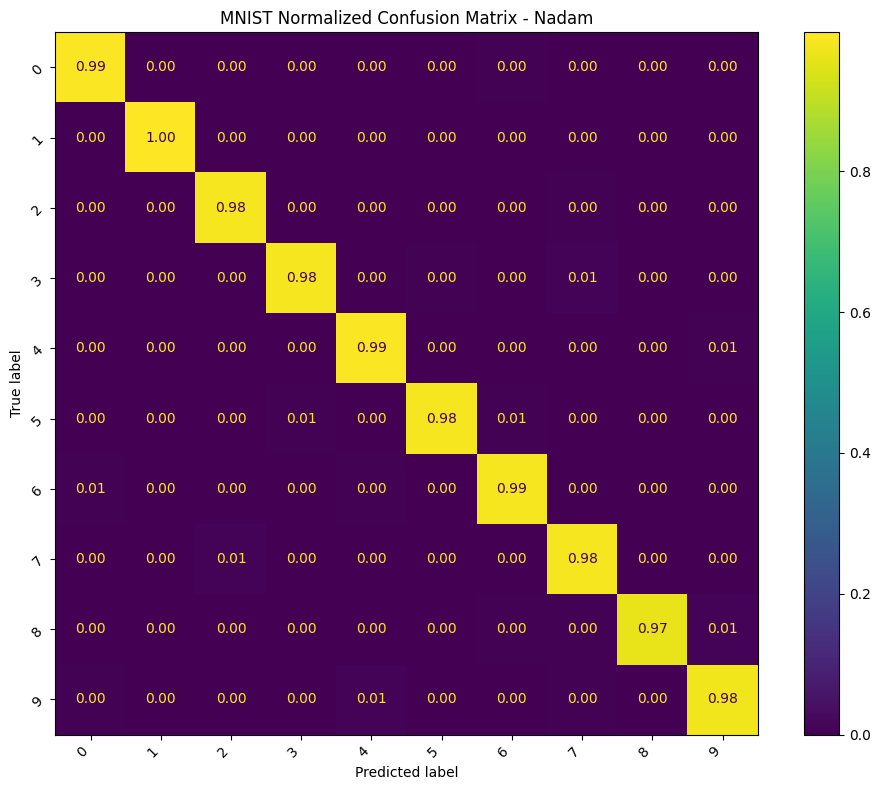

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot a confusion matrix with enhancements
def plot_confusion_matrix(cm, class_names, title, normalize=False):
    fig, ax = plt.subplots(figsize=(10, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        values_format = '.2f'  # Format for floating-point numbers
    else:
        values_format = 'd'    # Format for integers
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting confusion matrices for CIFAR-10
for opt in results_cifar:
    # Compute confusion matrix
    cm = confusion_matrix(results_cifar[opt]['targets'], np.argmax(results_cifar[opt]['probs'], axis=1))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Confusion Matrix - {opt}', normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Normalized Confusion Matrix - {opt}', normalize=True)

# Plotting confusion matrices for MNIST
for opt in results_mnist:
    # Compute confusion matrix
    cm = confusion_matrix(results_mnist[opt]['targets'], np.argmax(results_mnist[opt]['probs'], axis=1))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Confusion Matrix - {opt}', normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Normalized Confusion Matrix - {opt}', normalize=True)


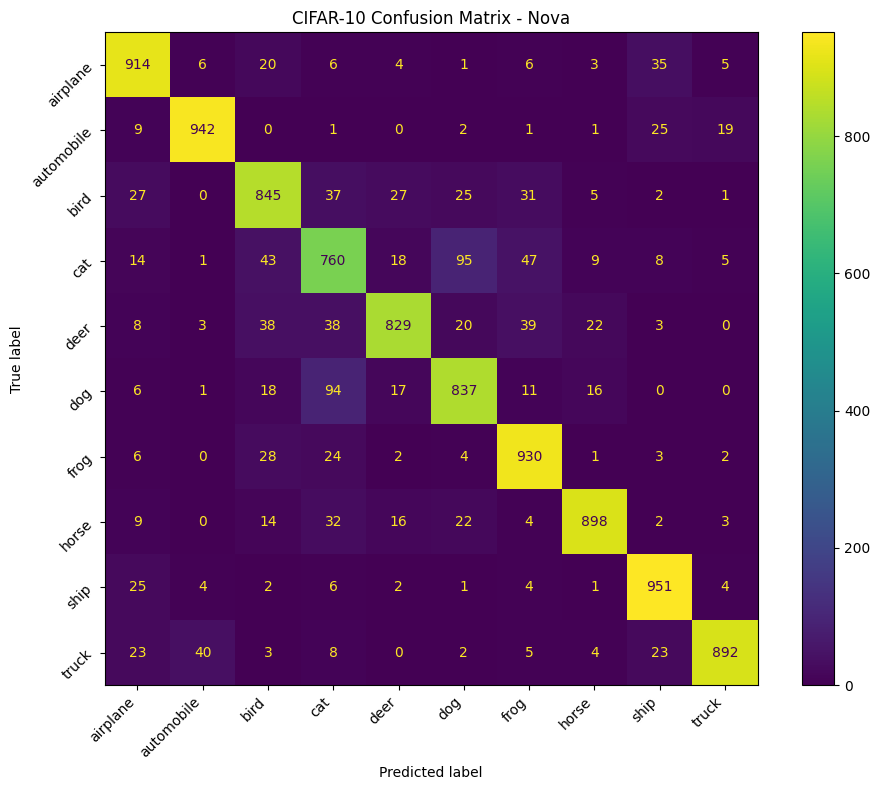

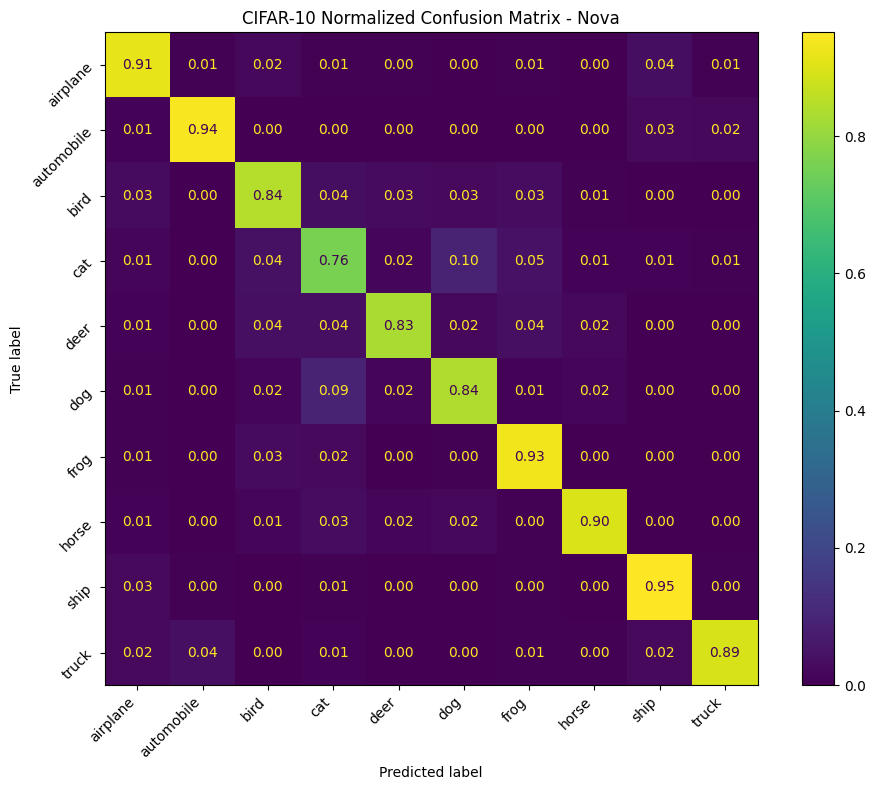

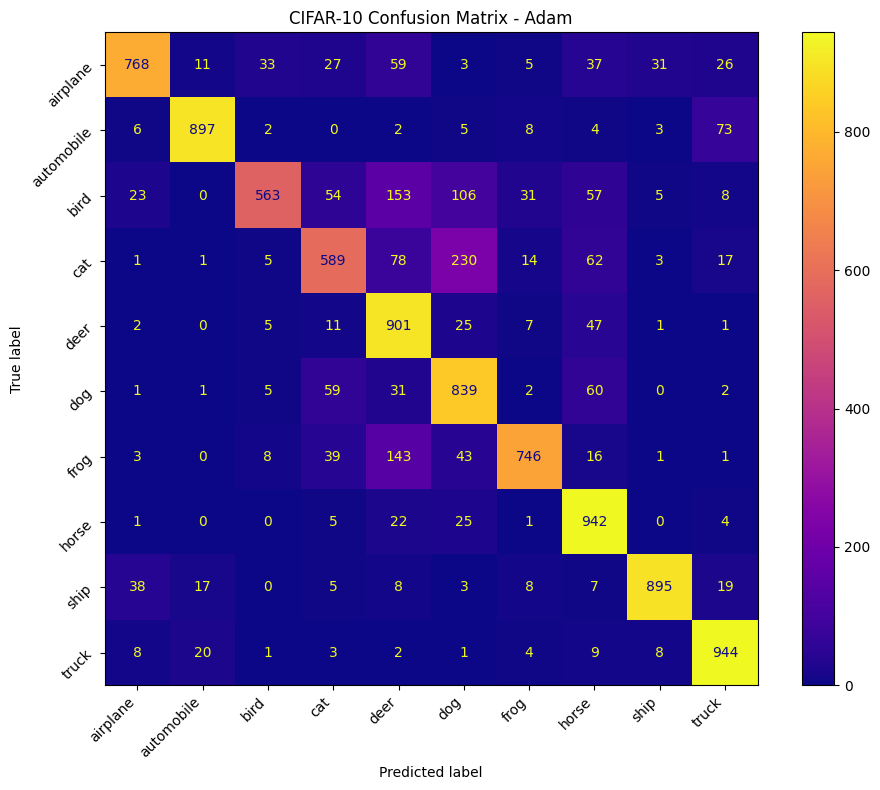

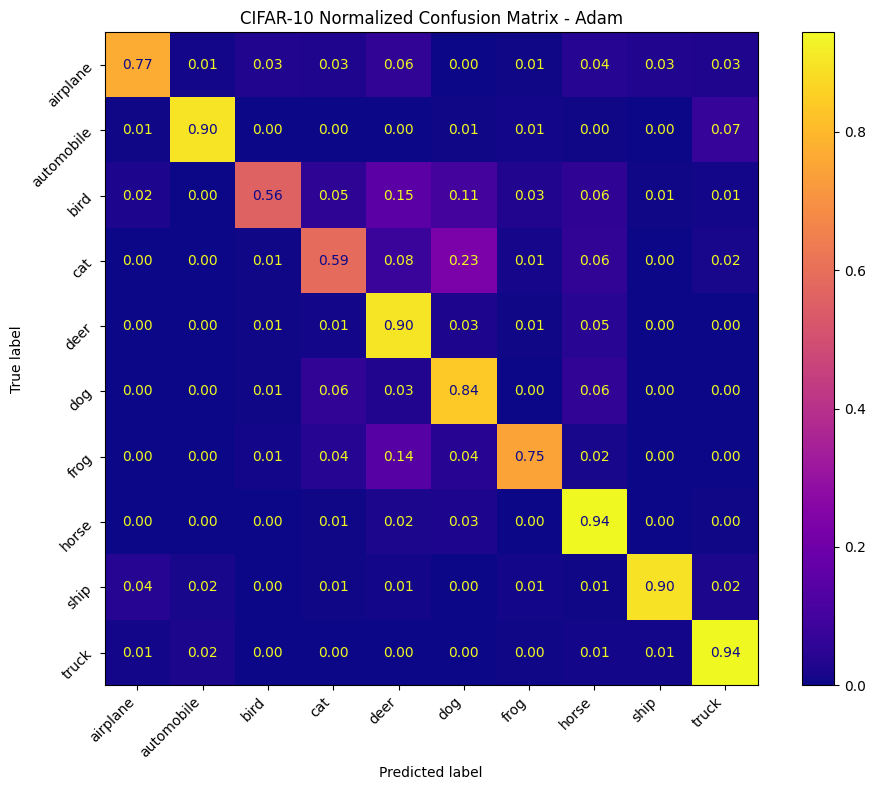

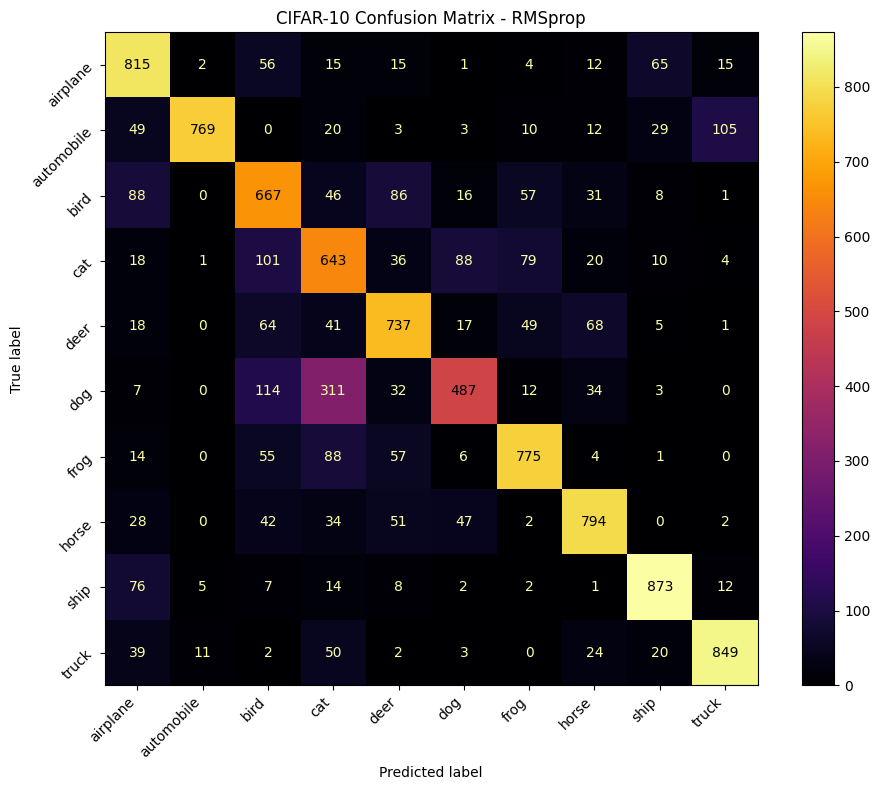

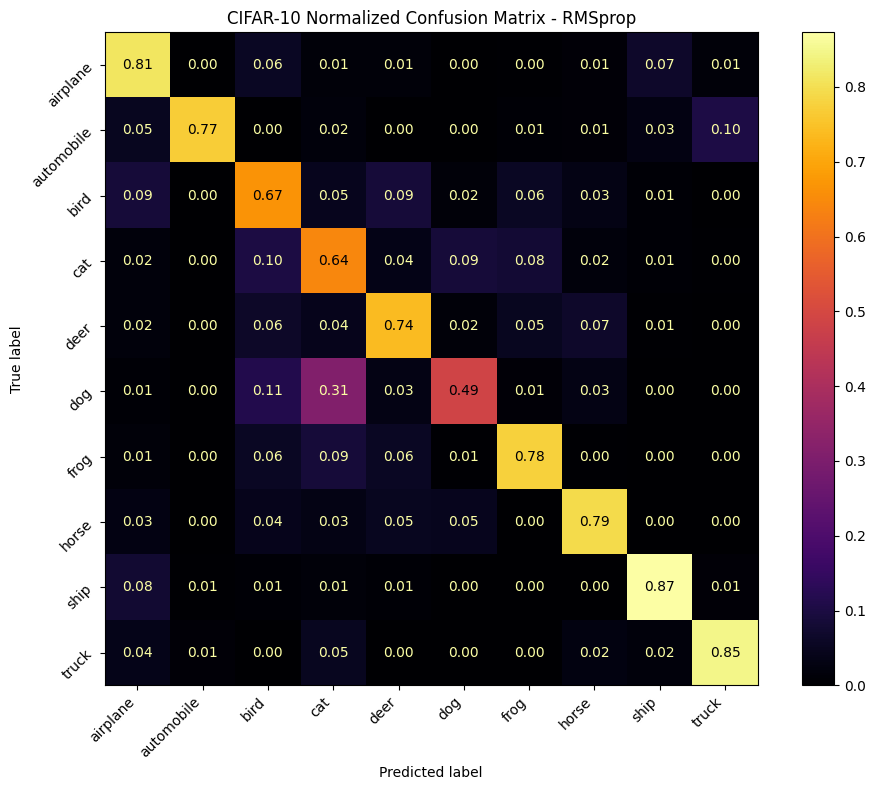

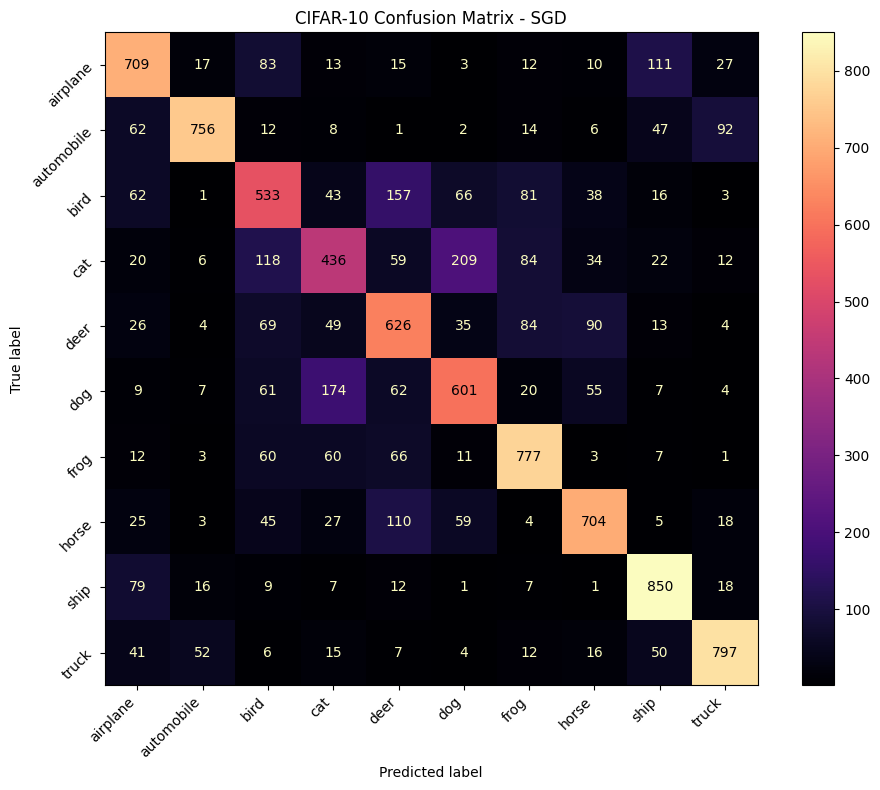

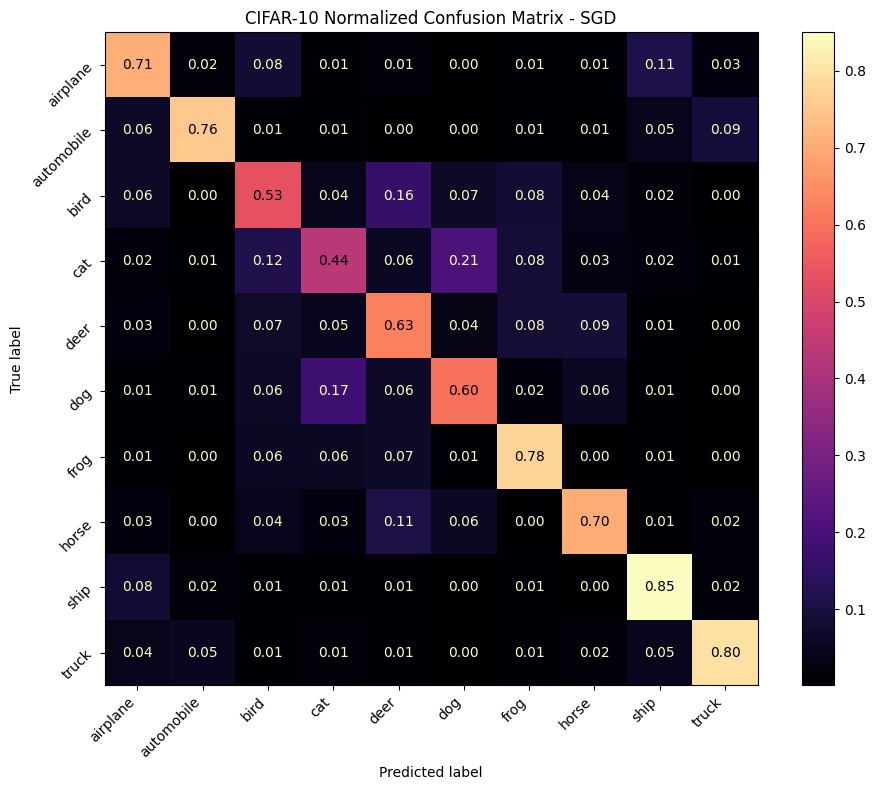

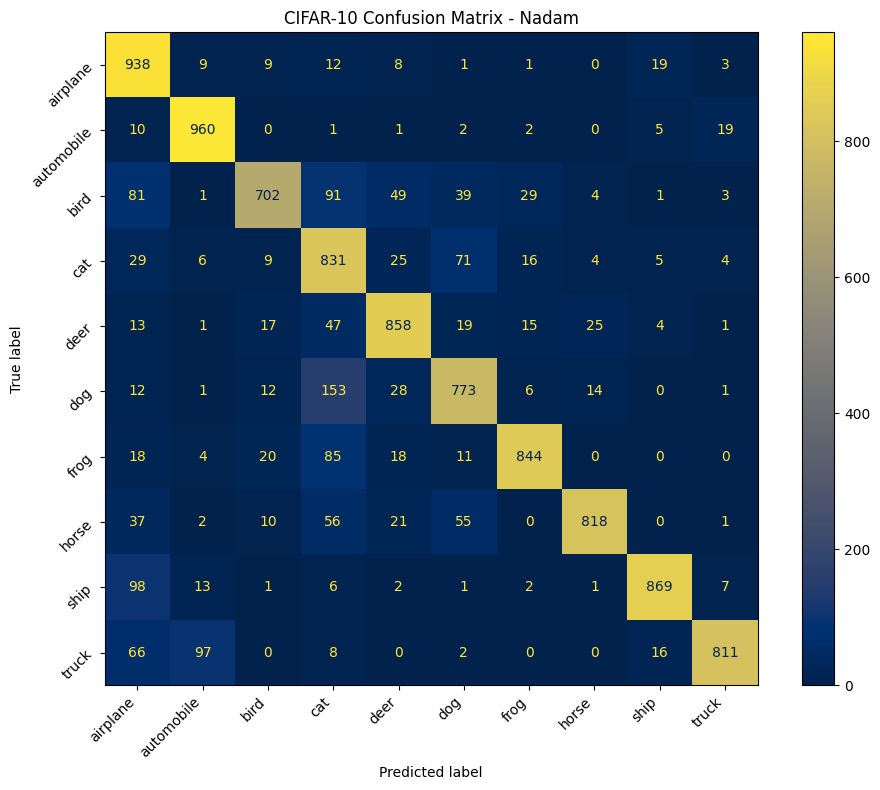

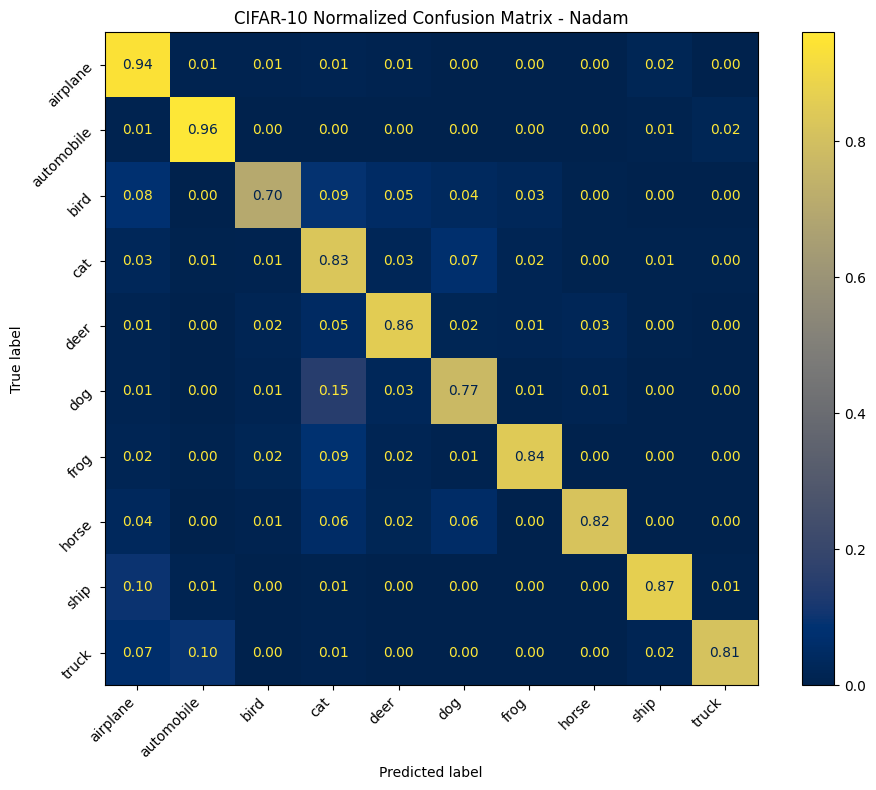

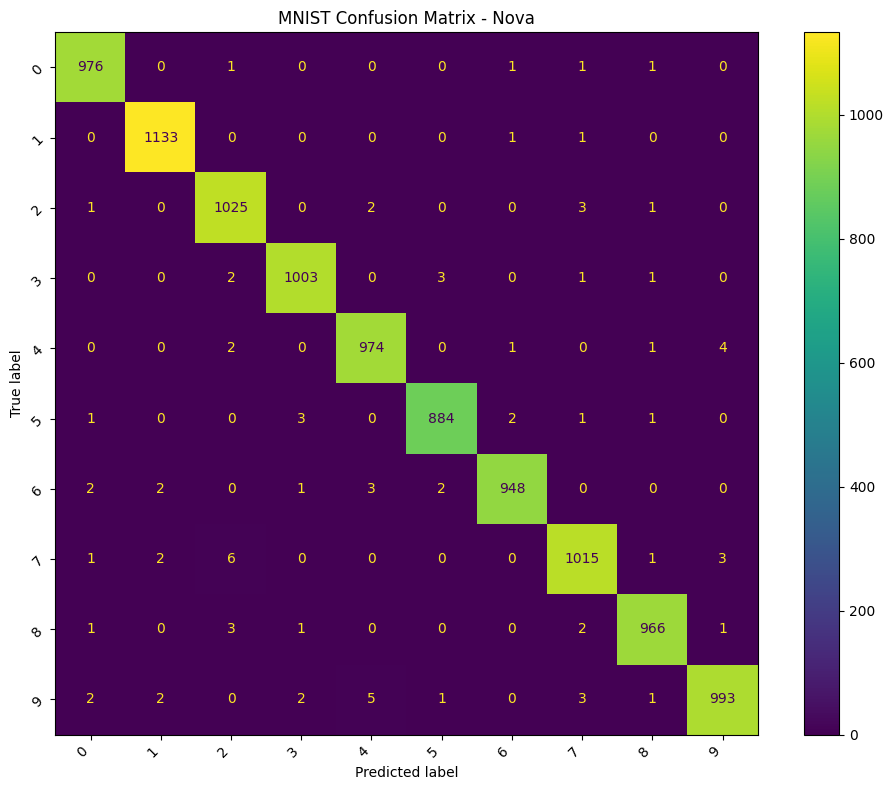

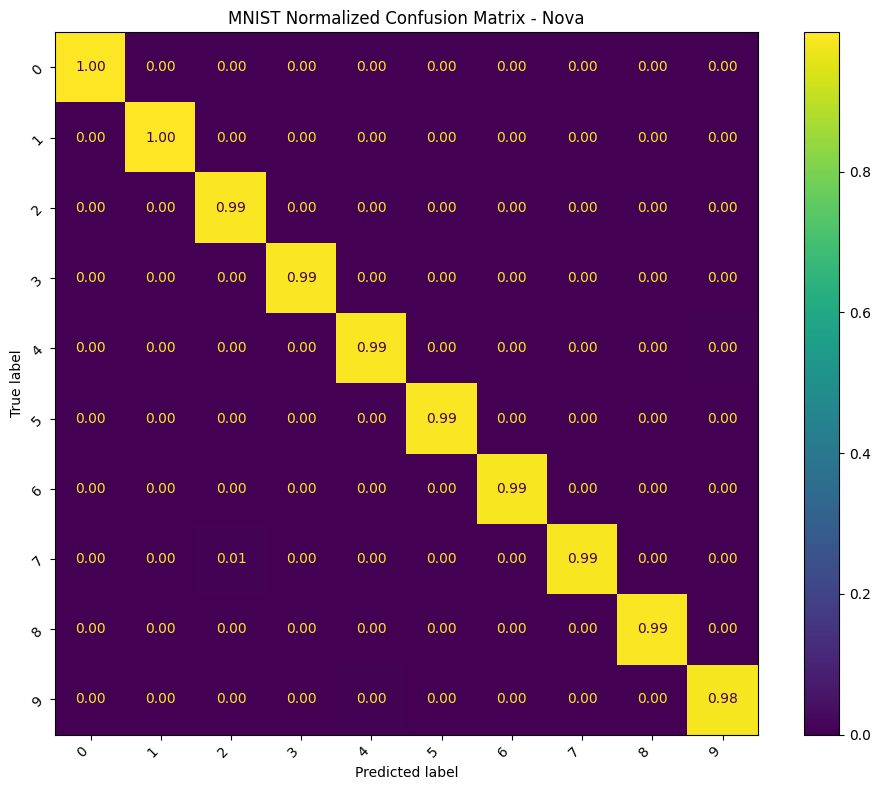

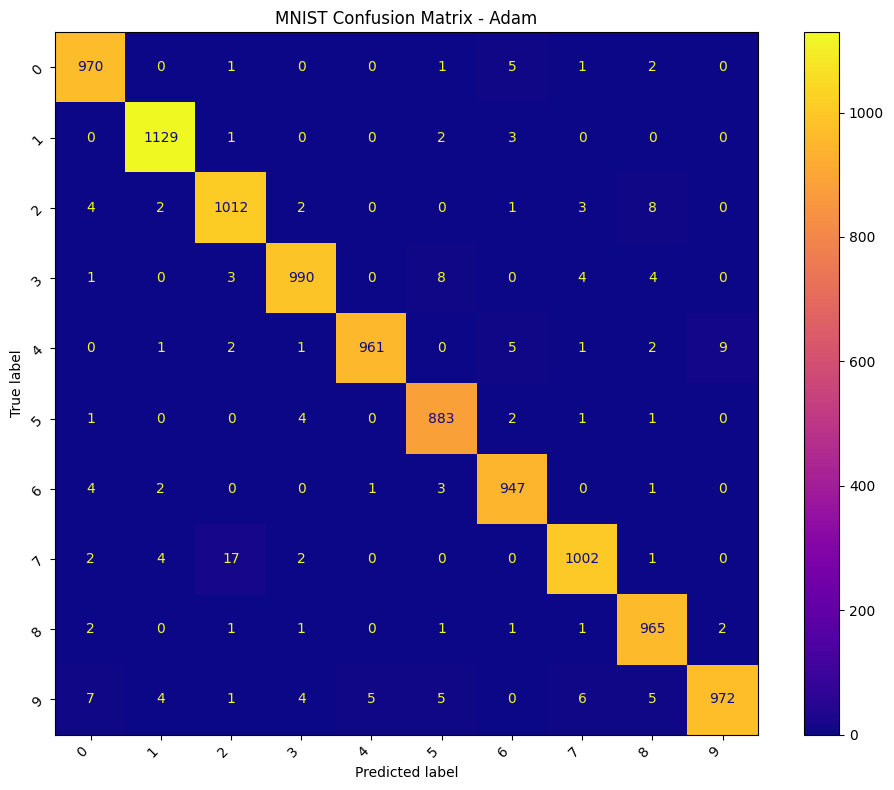

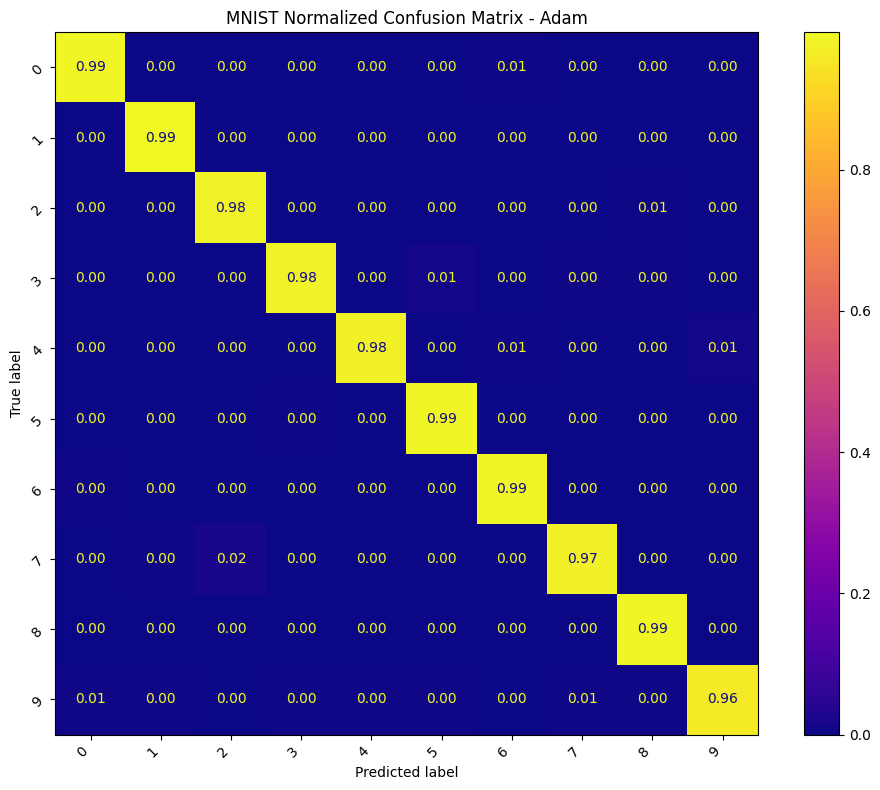

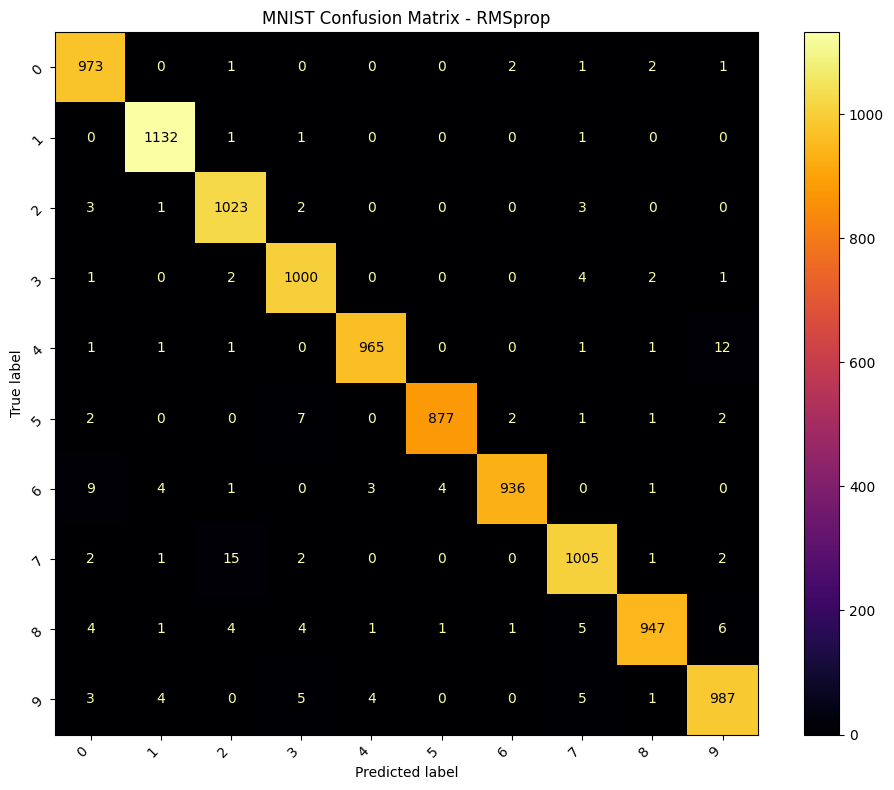

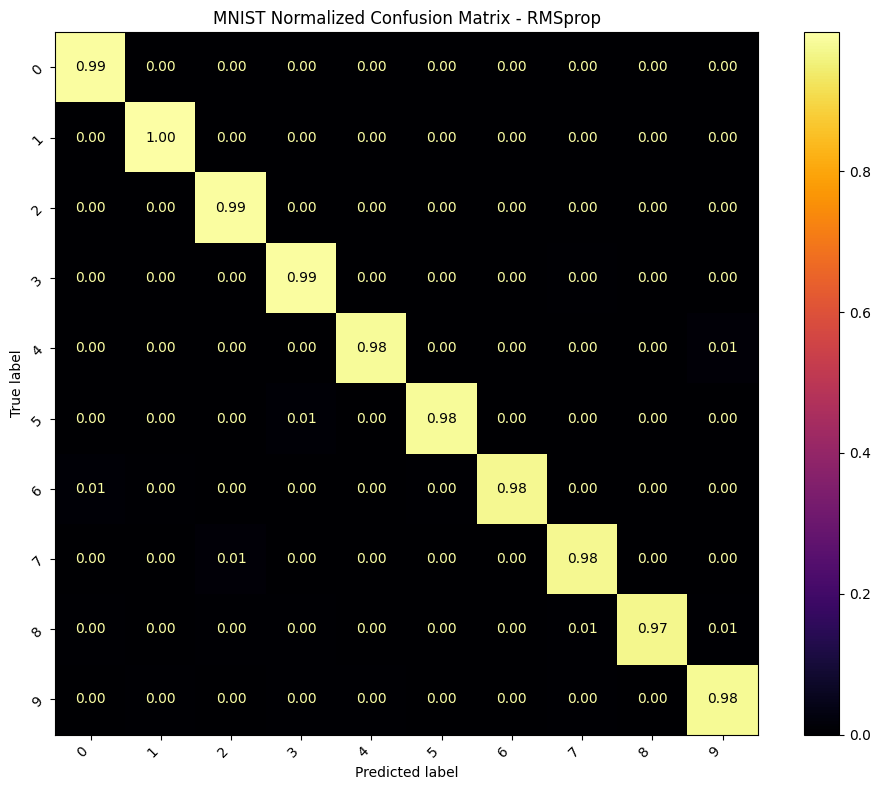

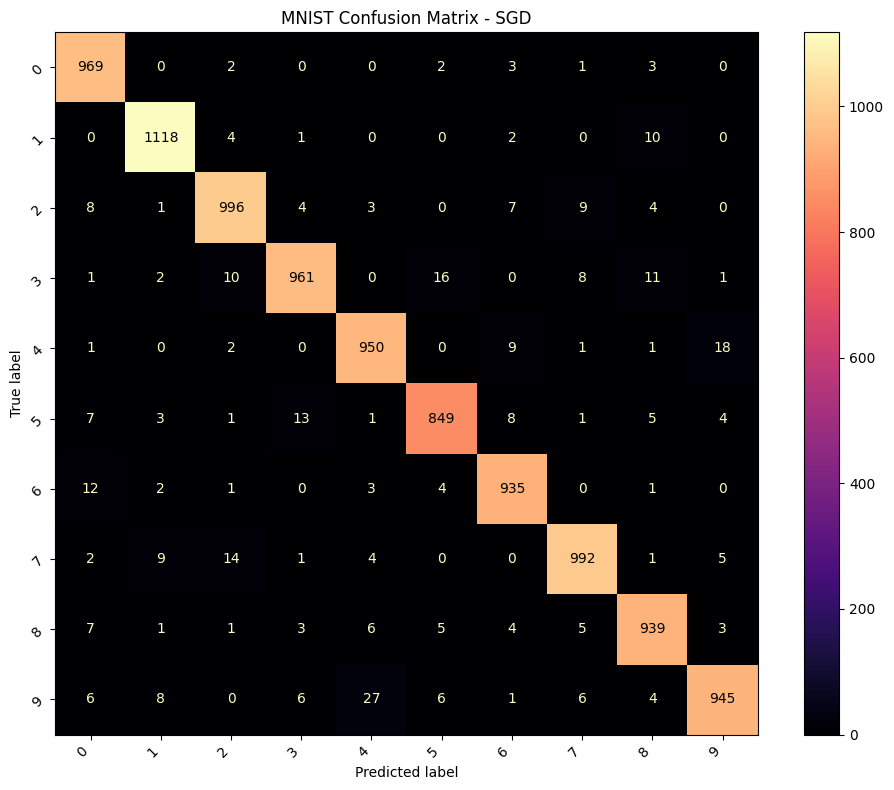

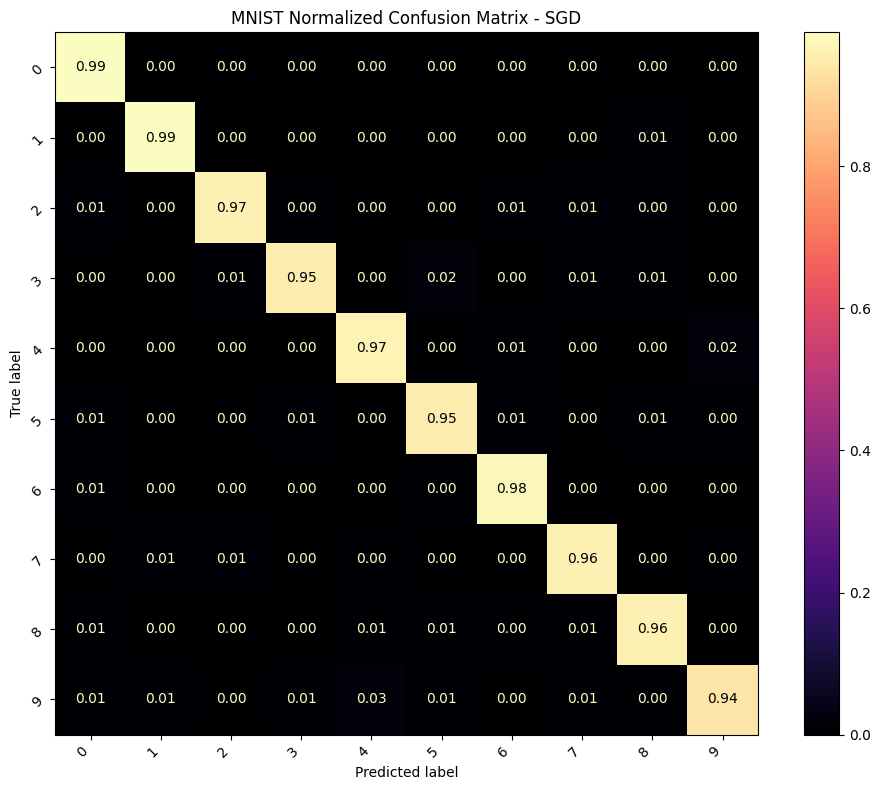

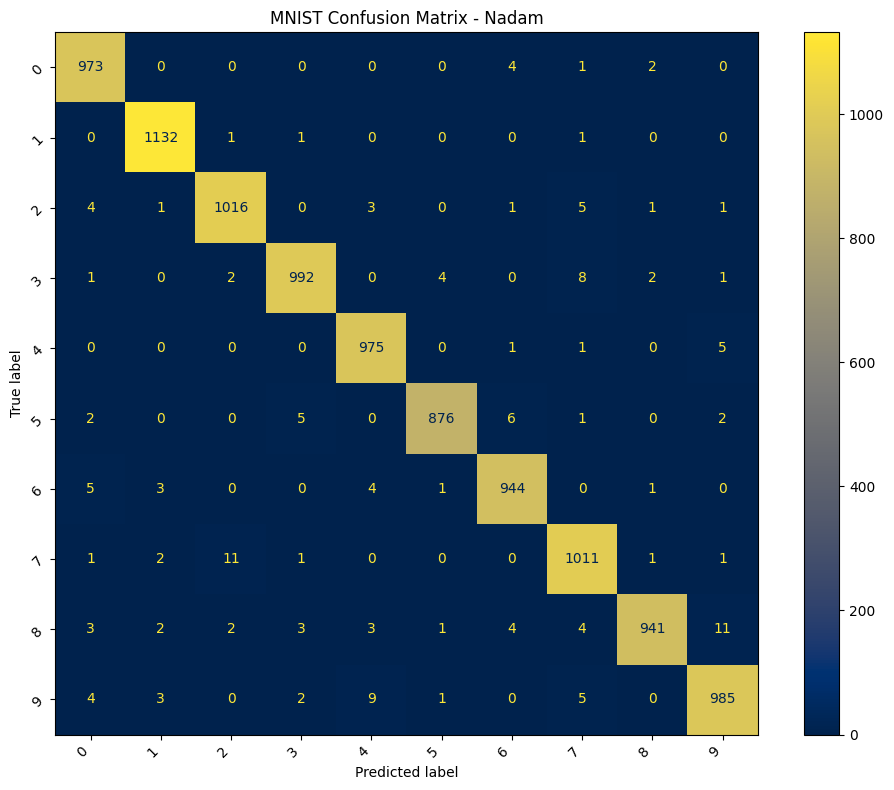

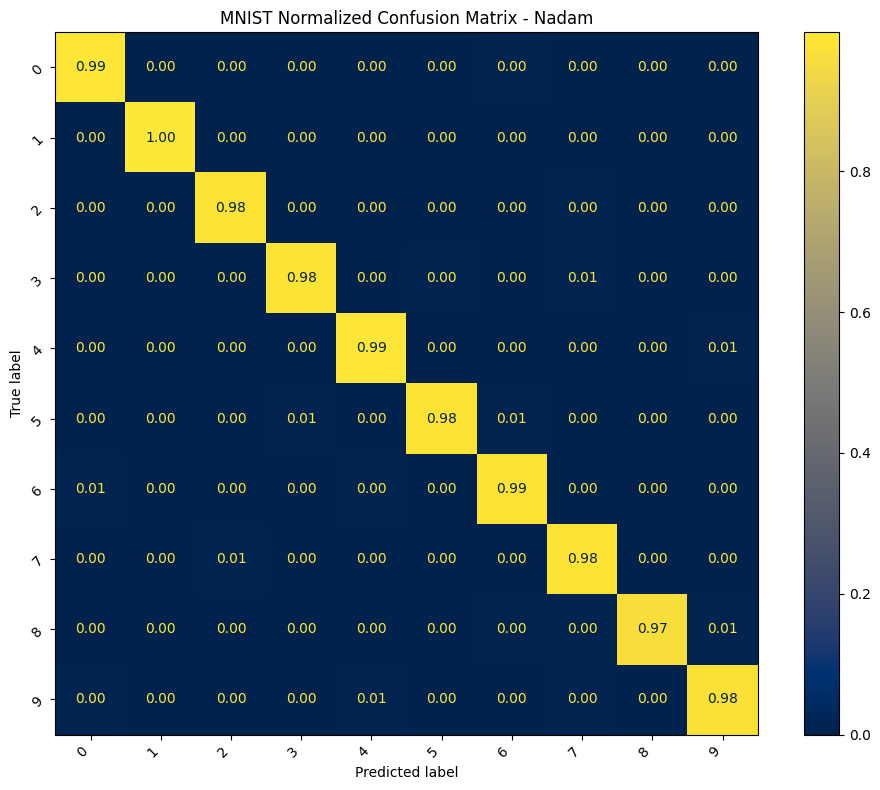

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# List of colormaps to use
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

# Function to plot a confusion matrix with enhancements
def plot_confusion_matrix(cm, class_names, title, cmap='viridis', normalize=False):
    fig, ax = plt.subplots(figsize=(10, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        values_format = '.2f'  # Format for floating-point numbers
    else:
        values_format = 'd'    # Format for integers
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=cmap, ax=ax, values_format=values_format, colorbar=True)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting confusion matrices for CIFAR-10
for idx, opt in enumerate(results_cifar):
    # Compute confusion matrix
    cm = confusion_matrix(results_cifar[opt]['targets'], np.argmax(results_cifar[opt]['probs'], axis=1))

    # Select colormap
    cmap = colormaps[idx % len(colormaps)]

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Confusion Matrix - {opt}', cmap=cmap, normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Normalized Confusion Matrix - {opt}', cmap=cmap, normalize=True)

# Plotting confusion matrices for MNIST
for idx, opt in enumerate(results_mnist):
    # Compute confusion matrix
    cm = confusion_matrix(results_mnist[opt]['targets'], np.argmax(results_mnist[opt]['probs'], axis=1))

    # Select colormap
    cmap = colormaps[idx % len(colormaps)]

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Confusion Matrix - {opt}', cmap=cmap, normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Normalized Confusion Matrix - {opt}', cmap=cmap, normalize=True)
